<h1><center>Quora Question Pair Similarity</center></h1>

<h1>1. Business Problem</h1>

<h2>1.1 Description</h2>

<p>Quora is an online platform designed for people to ask questions and share their knowledge on various topics. Its primary goal is to facilitate a collaborative environment where individuals can connect with others who can provide valuable insights and quality answers. The platform attracts over 100 million monthly visitors, emphasizing its popularity and widespread use.</p>

<p>Given the diversity of questions posed on Quora, it's common for users to ask similar or closely related queries. Recognizing that this repetition can potentially create challenges for both those seeking information and those providing answers, Quora places importance on the concept of "canonical questions".</p>

<p>Canonical questions are those that capture the essence of a particular inquiry in the most comprehensive and clear manner. The idea is to encourage users to phrase their questions in a way that minimizes redundancy. By doing so, this approach aims to enhance the overall user experience by making it easier for seekers to find the best answers to their questions and reducing the burden on contributors who might otherwise feel compelled to respond to multiple versions of the same question.</p>

<p>In essence, Quora values the creation of well-structured and definitive questions, as they contribute to a more efficient and beneficial exchange of knowledge among its users. This emphasis on canonical questions is intended to provide a lasting and valuable experience for both those seeking information and those sharing their expertise on the platform.</p>

<br>
<br>
<b>__Problem Statement__:</b>

<li>Identify which questions asked on Quora are duplicates of questions that have already been asked.</li>
<li>This could be useful to instantly provide answers to questions that have already been answered.</li>
<li>We are tasked with predicting whether a pair of questions are duplicates or not.</li>

<h2>1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints</h2>

<ol>
<li><b>High Cost of Mis-classification:</b>
<br>
In the context of question classification or matching, mis-classifying questions can lead to significant consequences. This implies that if the system incorrectly identifies two questions as duplicates or similar when they are not, it could result in undesirable outcomes. For instance, misclassifying questions on a medical forum might lead to incorrect advice being provided, emphasizing the importance of accuracy in question matching.</li>

<li><b>Desire for Probability Information:</b>
<br>
It seems you're highlighting the importance of having a probability associated with the classification of question pairs. This probabilistic measure allows for flexibility in decision-making. Instead of a rigid classification, where a system only says whether questions are duplicates or not, having a probability score allows users to set their own thresholds. This flexibility is valuable for fine-tuning the system to meet specific needs or preferences.</li>

<li><b>No Strict Latency Concerns:</b>
<br>
This suggests that the speed or response time of the system is not a critical factor. In some applications, especially real-time systems, low latency is crucial. However, in this context, it's implied that the system doesn't need to prioritize quick responses, allowing for more complex or resource-intensive processes to improve accuracy without compromising speed.</li>

<li><b>Partial Importance of Interpretability:</b>
<br>
Interpretability refers to the ease with which a human can understand and make sense of the decisions made by a machine learning model. The statement indicates that while it's important for the system to be interpretable to some extent, it's not an absolute priority. This balance between interpretability and other factors suggests a nuanced approach, where the model's decisions can be understood to a degree, but other considerations may take precedence.</li>
</ol>

<h1>2. Machine Learning Problem</h1>

<h2>2.1 Data</h2>

<h3>2.1.1 Data Overview</h3>

<li>Data will be in a file Train.csv</li>
<li>Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate</li>
<li>Size of Train.csv - 60MB</li>
<li>Number of rows in Train.csv = 404,290</li>

<h3>2.1.2 Example Data point</h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2>2.2 Mapping the real world problem to an ML problem<h2>

<h3>2.2.1 Type of Machine Leaning Problem</h3>

It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

<h3>2.2.2 Performance Metric.</h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2>2.3 Train and Test Construction</h2>

We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.

<h1>3. Exploratory Data Analysis</h1>

In [1]:
import os
import re
import time
import csv
import gc
import langid
import string
import distance
import nltk
import contractions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from subprocess import check_output
from nltk.corpus import stopwords, words
from nltk.stem import PorterStemmer
from langdetect import detect
from googletrans import Translator
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from tqdm import tqdm
from translate import Translator
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from deep_translator import GoogleTranslator
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
py.init_notebook_mode(connected=True)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SachinKapoor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SachinKapoor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\SachinKapoor\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

<h2> 3.1 Reading data and basic stats </h2>

In [2]:
try:
    df = pd.read_csv('train.csv')
except FileNotFoundError:
    print("Please check the path of CSV file.")
else:
    print("Succesfully load the data")

Succesfully load the data


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
print(f"we have {df.shape[0]} rows and {df.shape[1]} columns. ")

we have 404290 rows and 6 columns. 


In [5]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [6]:
print(f"we have {df.shape[0]} rows and {df.shape[1]} columns. ")

we have 404290 rows and 6 columns. 


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<b>Observations: </b>

<li>id: This appears to be a simple row ID, likely used for indexing or identification purposes.</li>

<li>qid{1, 2}: These seem to be unique IDs associated with each question in a pair.</li>

<li>question{1, 2}: These columns contain the actual textual contents of the questions.</li>

<li>is_duplicate: This is the label you are trying to predict, indicating whether the two questions in a pair are duplicates of each other.</li>

<li>Null values: There is one null value in the 'question1' column and two null values in the 'question2' column. Handling null values is important for many machine learning tasks, and you might consider imputing or removing them based on your specific needs.</li>

<h3> 3.2.1 Distribution of data points among output classes</h3>

In [8]:
# Calculate the percentage of each class label
class_percentages = df['is_duplicate'].value_counts(normalize=True) * 100

# Create an interactive bar chart
fig = px.bar(x=['Not Duplicate', 'Duplicate'],
             y=class_percentages.values,
             text=[f'{v:.2f}%' for v in class_percentages.values],
             title='Percentage Distribution of Class Labels',
             labels={'x': 'Class Label', 'y': 'Percentage'},
             color=['blue', 'orange'],
             )

# Update layout for better aesthetics (optional)
fig.update_layout(
    showlegend=False,  # Optional: set to True if you want to display legend
)

# Add percentage labels on top of each bar
fig.update_traces(textposition='outside')

# Show the plot
fig.show()

In [9]:
total_rows = df.shape[0]
not_duplicate_count = df.groupby('is_duplicate')['id'].count()[0]
duplicate_count = df.groupby('is_duplicate')['id'].count()[1]

print(f"Total rows: {total_rows}")
print(f"Count of 0 (Not duplicate): {not_duplicate_count} ({round(not_duplicate_count/total_rows*100, 2)}%)")
print(f"Count of 1 (Duplicate): {duplicate_count} ({round(duplicate_count/total_rows*100, 2)}%)")

Total rows: 404290
Count of 0 (Not duplicate): 255027 (63.08%)
Count of 1 (Duplicate): 149263 (36.92%)


<h3>3.2.2 Number of unique questions</h3>

In [10]:
# Combine 'qid1' and 'qid2' columns into a single Series
total_qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print("Total questions: ", len(total_qids))

# Calculate the total number of unique ids
unique_qids = len(total_qids.unique())
print(f"Total unique questions: {unique_qids} ({round(unique_qids/len(total_qids)*100, 2)}%)")

# Count the occurrences of each id
count_qids = total_qids.value_counts()

# Filter out ids that are not unique (occurs more than once)
not_unique_qids_counts = count_qids[count_qids > 1]
print(f"Number of unique questions that appear more than one time: {len(not_unique_qids_counts)} ({round(len(not_unique_qids_counts)/len(total_qids)*100, 2)}%)")

print("Max number of times a single question is repeated: ", max(count_qids))

print(f"The question which occured most no of times is: {df[df['qid1'] == 2559]['question1'].unique()}")

Total questions:  808580
Total unique questions: 537933 (66.53%)
Number of unique questions that appear more than one time: 111780 (13.82%)
Max number of times a single question is repeated:  157
The question which occured most no of times is: ['What are the best ways to lose weight?']


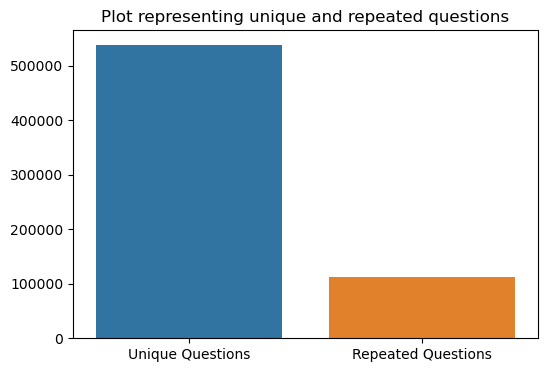

In [11]:
x = ["Unique Questions", "Repeated Questions"]
y = [unique_qids, len(not_unique_qids_counts)]

plt.figure(figsize=(6, 4))
plt.title("Plot representing unique and repeated questions")
sns.barplot(x=x, y=y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [12]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

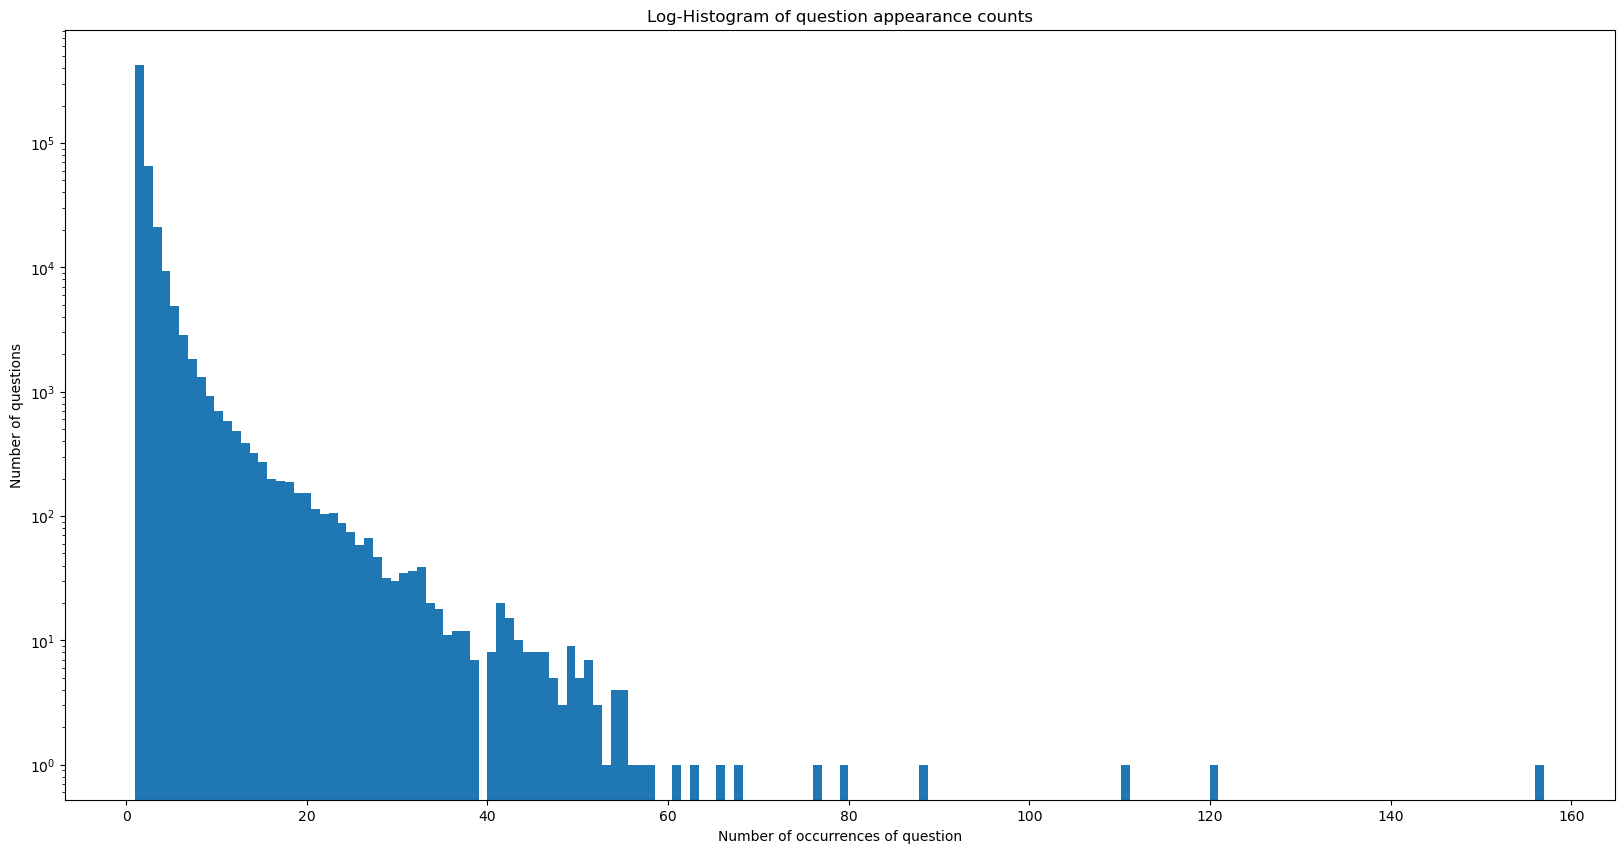

In [13]:
plt.figure(figsize=(20, 10))

# Assuming total_qids is your Series
counts = total_qids.value_counts()
plt.hist(counts, bins=160)

plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurrences of question')
plt.ylabel('Number of questions')
plt.show()

<h3> 3.2.5 Checking for NULL values </h3>

In [14]:
null_count_question1 = df["question1"].isnull().sum()
print("Total no. of rows where we have null value in question1: ", null_count_question1)
rows_with_nulls = df[df["question1"].isnull()]
rows_with_nulls

Total no. of rows where we have null value in question1:  1


,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [15]:
null_count_question2 = df["question2"].isnull().sum()
print("Total no. of rows where we have null value in question2: ", null_count_question2)
rows_with_nulls = df[df["question2"].isnull()]
rows_with_nulls

Total no. of rows where we have null value in question2:  2


,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [18]:
df = df.dropna(subset=['question1'])
df = df.dropna(subset=['question2'])
print("After deleting the rows where we have null values: ",df.shape[0])

After deleting the rows where we have null values:  404287


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

<h3>3.3.1 Convert the non english text to english text</h3>

In [17]:
def translate_text(text, target_language='en'):
    try:
        translator = Translator(to_lang=target_language)
        translation = translator.translate(text)
        return translation
    except Exception as e:
        return f"An error occurred: {str(e)}"

# Assuming df is your DataFrame
# Apply translation function to each row in the DataFrame using tqdm for progress tracking
tqdm.pandas(desc="Translating", unit="row")

# Create new columns for translated text
df['question1'] = df['question1'].progress_apply(translate_text)
df['question2'] = df['question2'].progress_apply(translate_text)

Translating: 100%|██████████| 404287/404287 [00:02<00:00, 196763.23row/s]


<h3>3.3.2 Check the text belongs to english or not</h3>

In [ ]:
# # Function to check if any non-English word is present in a given text
# def has_non_english_word(text):
#     words = text.split()
#     for word in words:
#         if langid.classify(word)[0] != 'en':  # 'en' represents English language
#             print(word)
#             return True
#     return False

# # Apply the function to each row in the DataFrame with tqdm
# non_english_rows = []
# for index, row in tqdm(df.iterrows(), total=len(df), desc="Checking rows"):
#     if has_non_english_word(row['question1']) or has_non_english_word(row['question2']):
#         non_english_rows.append(index)

Checking rows:   0%|          | 4/404287 [00:02<52:20:53,  2.15it/s] 

(Koh-i-Noor)
Capricorn


Checking rows:   0%|          | 14/404287 [00:02<11:20:14,  9.91it/s]

シ
Charter
technicians


Checking rows:   0%|          | 20/404287 [00:02<7:18:40, 15.36it/s] 

visa
visa?
want
digital



Checking rows:   0%|          | 24/404287 [00:03<5:58:01, 18.82it/s]

causing


Checking rows:   0%|          | 30/404287 [00:03<5:47:16, 19.40it/s]

Medicines?



Checking rows:   0%|          | 35/404287 [00:03<4:40:23, 24.03it/s]

despite
cares
Thrones
still
guns
entrepreneur


Checking rows:   0%|          | 41/404287 [00:03<4:35:02, 24.50it/s]

want
aircraft
Slavs
Cognizant
being



Checking rows:   0%|          | 45/404287 [00:03<3:59:43, 28.10it/s]

recruit
Legends?


Checking rows:   0%|          | 52/404287 [00:04<4:53:46, 22.93it/s]

Career
Nd
memorable


Checking rows:   0%|          | 62/404287 [00:04<5:06:38, 21.97it/s]

longer
genders?
kickass


Checking rows:   0%|          | 71/404287 [00:05<5:41:10, 19.75it/s]

lightning?
enjoy



Checking rows:   0%|          | 74/404287 [00:05<5:18:19, 21.16it/s]

English
richest
aircraft


Checking rows:   0%|          | 86/404287 [00:05<4:00:09, 28.05it/s]

Christians
etiquette
wants
despise
salary
cambodia
fairness?


Checking rows:   0%|          | 97/404287 [00:06<3:37:07, 31.03it/s]

chemistry
Kurukshetra:
romantic
expressionism
Jeremy
horcrux?


Checking rows:   0%|          | 105/404287 [00:06<4:34:47, 24.52it/s]

android
attack?
Ronald
Confederates



Checking rows:   0%|          | 109/404287 [00:06<4:32:57, 24.68it/s]

higher



Checking rows:   0%|          | 112/404287 [00:06<5:05:56, 22.02it/s]

english


Checking rows:   0%|          | 120/404287 [00:07<6:17:24, 17.85it/s]

(digital)


Checking rows:   0%|          | 127/404287 [00:07<5:05:21, 22.06it/s]

neutral
mineral
imbalance
Jaish-e-Mohammad
Vitamin



Checking rows:   0%|          | 132/404287 [00:07<4:01:01, 27.95it/s]

Asahi
Torbox
yakshini
young


Checking rows:   0%|          | 142/404287 [00:08<4:45:29, 23.59it/s]

hair
polo


Checking rows:   0%|          | 150/404287 [00:08<3:59:50, 28.08it/s]

racism,
Waveclues?
pencils
Seinfeld
rabies
ruled
being


Checking rows:   0%|          | 159/404287 [00:08<3:36:28, 31.11it/s]

Snoke
monetize
Leica



Checking rows:   0%|          | 163/404287 [00:08<3:57:30, 28.36it/s]

Chelmsford-Essex,


Checking rows:   0%|          | 169/404287 [00:09<4:29:09, 25.02it/s]

earphones
Sukanya
engineering


Checking rows:   0%|          | 175/404287 [00:09<4:35:56, 24.41it/s]

coworkers/bosses
salary
prospering
gods


Checking rows:   0%|          | 181/404287 [00:09<4:29:51, 24.96it/s]

Köln,
Niro
being
ordered


Checking rows:   0%|          | 187/404287 [00:09<5:08:14, 21.85it/s]

android
contrast
then


Checking rows:   0%|          | 194/404287 [00:10<4:38:00, 24.23it/s]

Ben
Hyderabad?
being
enhance
screenshot
recruiter
psychological


Checking rows:   0%|          | 202/404287 [00:10<4:17:28, 26.16it/s]

die?
₹500
billionaire($)?
lectures



Checking rows:   0%|          | 205/404287 [00:10<5:31:13, 20.33it/s]

Hillary
care
gods,


Checking rows:   0%|          | 214/404287 [00:10<3:50:19, 29.24it/s]

assassin
inkjet
Hillary
headphones
engineers
benefits
continuous?
neutron


Checking rows:   0%|          | 222/404287 [00:11<3:47:25, 29.61it/s]

Harvard?
utilize
started



Checking rows:   0%|          | 226/404287 [00:11<4:21:10, 25.79it/s]

wireless
dollar
(Linux
digestion?
waiting


Checking rows:   0%|          | 233/404287 [00:11<5:05:18, 22.06it/s]

Legends?
run



Checking rows:   0%|          | 239/404287 [00:11<4:15:52, 26.32it/s]

supporters,
care
potty
jump
science
understanding


Checking rows:   0%|          | 245/404287 [00:12<4:54:23, 22.87it/s]

lighter).
Raisin
intelligence?



Checking rows:   0%|          | 249/404287 [00:12<4:59:18, 22.50it/s]

run
₹5000


Checking rows:   0%|          | 255/404287 [00:12<5:21:17, 20.96it/s]

illness
spitting
straits?
Narendra


Checking rows:   0%|          | 262/404287 [00:12<4:32:36, 24.70it/s]

franchise
medicine?
egg
waiting
pros
journal



Checking rows:   0%|          | 265/404287 [00:13<4:26:37, 25.26it/s]

resolution
Slavs
broken?


Checking rows:   0%|          | 271/404287 [00:13<4:54:23, 22.87it/s]

Android
fair,
prisoner?
suffering


Checking rows:   0%|          | 282/404287 [00:13<4:47:06, 23.45it/s]

wait
die?
instead
Reddice?



Checking rows:   0%|          | 286/404287 [00:13<4:32:17, 24.73it/s]

still
travelling
delicious
Delhi's


Checking rows:   0%|          | 292/404287 [00:14<4:50:00, 23.22it/s]

repairing
McDonald's
raise?
Hazare


Checking rows:   0%|          | 299/404287 [00:14<4:45:48, 23.56it/s]

eccentric
beer


Checking rows:   0%|          | 311/404287 [00:15<4:52:06, 23.05it/s]

diesel
Bachelors
understand
unwritten


Checking rows:   0%|          | 317/404287 [00:15<5:03:52, 22.16it/s]

voices?
predict
being
billionaire?


Checking rows:   0%|          | 324/404287 [00:15<4:10:23, 26.89it/s]

calender/scheduling/booking
understanding
considered


Checking rows:   0%|          | 330/404287 [00:15<4:28:55, 25.03it/s]

eaten
Switzerland?
journalism


Checking rows:   0%|          | 336/404287 [00:16<5:12:15, 21.56it/s]

pros
deism
ejaculate?


Checking rows:   0%|          | 344/404287 [00:16<5:10:32, 21.68it/s]

jailbreaking
smoking?
Stewart
desperate?



Checking rows:   0%|          | 347/404287 [00:16<5:16:48, 21.25it/s]

daddy
mobile


Checking rows:   0%|          | 358/404287 [00:17<4:19:40, 25.92it/s]

Harvard
Android
written?
recruit
Psychology)?
Industries


Checking rows:   0%|          | 364/404287 [00:17<4:18:16, 26.07it/s]

racist
zeros



Checking rows:   0%|          | 368/404287 [00:17<3:50:48, 29.17it/s]

Narendra
electable
bastards


Checking rows:   0%|          | 377/404287 [00:17<4:27:15, 25.19it/s]

debeak
avoid
avoid
bisexual
engineering?


Checking rows:   0%|          | 384/404287 [00:18<4:08:43, 27.06it/s]

massaging
Mangalore?
still
Liquid
companies
emoticon?
discharge



Checking rows:   0%|          | 389/404287 [00:18<3:37:45, 30.91it/s]

finger
vellore?
Preferable


Checking rows:   0%|          | 396/404287 [00:18<4:04:31, 27.53it/s]

Shahrukh
continuation


Checking rows:   0%|          | 402/404287 [00:18<4:27:43, 25.14it/s]

argued
hair
injuries


Checking rows:   0%|          | 411/404287 [00:19<4:40:16, 24.02it/s]

want
Federation
Titania
divorce?
hair
Donald


Checking rows:   0%|          | 417/404287 [00:19<4:20:22, 25.85it/s]

rich
beneficial:
sandeep
monster


Checking rows:   0%|          | 429/404287 [00:19<4:51:20, 23.10it/s]

can’t
spouse
hostel
Staten
avocado
Airtel
Hillary
stuffy


Checking rows:   0%|          | 439/404287 [00:20<3:17:10, 34.14it/s]

English
protein
Jones
instead
fall
Marvel



Checking rows:   0%|          | 443/404287 [00:20<4:10:23, 26.88it/s]

jingle?
imported


Checking rows:   0%|          | 450/404287 [00:20<5:02:56, 22.22it/s]

piano?
plus
adopted


Checking rows:   0%|          | 456/404287 [00:20<4:50:59, 23.13it/s]

being
considered
anymore.



Checking rows:   0%|          | 459/404287 [00:21<4:35:01, 24.47it/s]

knight?
kidnap


Checking rows:   0%|          | 468/404287 [00:21<5:31:50, 20.28it/s]

begets
then
pizza?



Checking rows:   0%|          | 471/404287 [00:21<6:02:06, 18.59it/s]

mountaineering


Checking rows:   0%|          | 478/404287 [00:22<4:57:55, 22.59it/s]

Interstellar?
fighter
salary
halted?



Checking rows:   0%|          | 481/404287 [00:22<5:08:13, 21.83it/s]

M.K.Gandhi?
pounds
Pokémon


Checking rows:   0%|          | 491/404287 [00:22<4:36:57, 24.30it/s]

Android?
Rahul
asteroid?


Checking rows:   0%|          | 499/404287 [00:22<3:57:51, 28.29it/s]

chocolate
higher
Tennessee?
hair


Checking rows:   0%|          | 505/404287 [00:23<4:11:37, 26.74it/s]

cause
seekers?
baking
Zika
algebra



Checking rows:   0%|          | 510/404287 [00:23<3:39:39, 30.64it/s]

prospects?
Christian
vaijanti?


Checking rows:   0%|          | 518/404287 [00:23<4:21:28, 25.74it/s]

anemia
cause
techniques?


Checking rows:   0%|          | 525/404287 [00:23<4:22:50, 25.60it/s]

exercise
egg
highest
sprain?



Checking rows:   0%|          | 528/404287 [00:23<4:12:49, 26.62it/s]

foreigners


Checking rows:   0%|          | 536/404287 [00:24<4:24:07, 25.48it/s]

Donald
various
imminent
Narendra
want


Checking rows:   0%|          | 545/404287 [00:24<4:05:24, 27.42it/s]

android?
want
science
necessary
engineer?
Judaism
desired



Checking rows:   0%|          | 549/404287 [00:24<4:31:15, 24.81it/s]

fellowship
mobile


Checking rows:   0%|          | 555/404287 [00:25<5:00:58, 22.36it/s]

various



Checking rows:   0%|          | 559/404287 [00:25<4:42:17, 23.84it/s]

Engineers
engineer


Checking rows:   0%|          | 566/404287 [00:25<4:41:16, 23.92it/s]

Digest
highlighting
ordered


Checking rows:   0%|          | 572/404287 [00:25<4:51:12, 23.11it/s]

started
being


Checking rows:   0%|          | 578/404287 [00:26<5:16:06, 21.29it/s]

solar
run
studies?
academic
Urjit
want


Checking rows:   0%|          | 586/404287 [00:26<4:25:49, 25.31it/s]

care
being
engineering


Checking rows:   0%|          | 599/404287 [00:26<4:39:12, 24.10it/s]

want
highest
resolve


Checking rows:   0%|          | 606/404287 [00:27<4:12:48, 26.61it/s]

huge
phenotypic
benefit
jet?



Checking rows:   0%|          | 609/404287 [00:27<4:18:57, 25.98it/s]

wired
imminent
prunes
taken


Checking rows:   0%|          | 615/404287 [00:27<4:31:27, 24.78it/s]

harnessed
want


Checking rows:   0%|          | 622/404287 [00:27<4:15:13, 26.36it/s]

indicator
opinion,
Hungary?
science?


Checking rows:   0%|          | 628/404287 [00:28<4:08:13, 27.10it/s]

boss
refugee


Checking rows:   0%|          | 636/404287 [00:28<4:14:38, 26.42it/s]

Fallacies:
written-off
Hobbit
dun
begineer?
Supreme



Checking rows:   0%|          | 640/404287 [00:28<4:45:19, 23.58it/s]

gentleman?
Mobile
negative


Checking rows:   0%|          | 648/404287 [00:28<4:08:43, 27.05it/s]

English
school


Checking rows:   0%|          | 654/404287 [00:29<4:16:33, 26.22it/s]

calories
stress
scientific


Checking rows:   0%|          | 662/404287 [00:29<4:00:34, 27.96it/s]

anger?
genders?
raw
smartphones
dictatorship


Checking rows:   0%|          | 674/404287 [00:29<5:30:55, 20.33it/s]

stamp
recursion
android
piano?



Checking rows:   0%|          | 678/404287 [00:30<5:08:03, 21.84it/s]

opinion
Bengaluru?
chemistry?
essence


Checking rows:   0%|          | 684/404287 [00:30<5:05:59, 21.98it/s]

minestrone
gold


Checking rows:   0%|          | 690/404287 [00:30<5:47:19, 19.37it/s]

Galileo?
issued
run
modifiers?
poetry


Checking rows:   0%|          | 700/404287 [00:31<4:13:25, 26.54it/s]

bend
skirt?
Maserati


Checking rows:   0%|          | 706/404287 [00:31<4:34:35, 24.50it/s]

science
towards


Checking rows:   0%|          | 718/404287 [00:31<3:19:11, 33.77it/s]

latency
science.
pandas
Engineering
fastest
being



Checking rows:   0%|          | 722/404287 [00:31<4:00:10, 28.00it/s]

scenario:
seconds…



Checking rows:   0%|          | 726/404287 [00:32<4:13:33, 26.53it/s]

seen?


Checking rows:   0%|          | 732/404287 [00:32<5:04:20, 22.10it/s]

imported
dangerous?
fail?
amazing


Checking rows:   0%|          | 738/404287 [00:32<4:56:37, 22.67it/s]

then
English
intelligence
school


Checking rows:   0%|          | 746/404287 [00:32<4:03:01, 27.68it/s]

screenshot
science
English,
hypodensity
salary?
Psychopaths:
choir
shunned
declare


Checking rows:   0%|          | 755/404287 [00:33<4:00:02, 28.02it/s]

fantasy


Checking rows:   0%|          | 764/404287 [00:33<3:29:39, 32.08it/s]

Wales
Cochin
resolution
Balaji
habib
barvaria
“her”



Checking rows:   0%|          | 769/404287 [00:33<3:26:51, 32.51it/s]

vertebral
curriculum?
want


Checking rows:   0%|          | 781/404287 [00:34<4:06:33, 27.28it/s]

'contorted'
dizzy
companies
seen?
neural
wearable



Checking rows:   0%|          | 784/404287 [00:34<4:39:18, 24.08it/s]

Prez


Checking rows:   0%|          | 790/404287 [00:34<5:52:23, 19.08it/s]

science
Salman



Checking rows:   0%|          | 794/404287 [00:34<4:55:43, 22.74it/s]

fossil
Hizmet
necessary
vaginal
Cincinnati,


Checking rows:   0%|          | 805/404287 [00:35<4:00:10, 28.00it/s]

nutrients
handling
benefit
started
mobile
truly


Checking rows:   0%|          | 815/404287 [00:35<4:40:51, 23.94it/s]

schools
supporters
fall
remedies



Checking rows:   0%|          | 819/404287 [00:35<4:45:32, 23.55it/s]

verbal?
liasioning
gotta


Checking rows:   0%|          | 826/404287 [00:36<4:53:03, 22.95it/s]

Hyderabad?



Checking rows:   0%|          | 829/404287 [00:36<4:56:29, 22.68it/s]

Timbaland


Checking rows:   0%|          | 836/404287 [00:36<4:28:56, 25.00it/s]

want
cause
Chandigarh?
Bangalore?


Checking rows:   0%|          | 842/404287 [00:36<5:39:54, 19.78it/s]

recieved


Checking rows:   0%|          | 849/404287 [00:37<4:59:20, 22.46it/s]

Alduin?
religious
Heisenberg


Checking rows:   0%|          | 856/404287 [00:37<4:19:34, 25.90it/s]

exercise
digital
gangster?
layman's
vomits



Checking rows:   0%|          | 860/404287 [00:37<3:55:55, 28.50it/s]

truly
Zealand



Checking rows:   0%|          | 863/404287 [00:37<4:30:46, 24.83it/s]

benefits
younger


Checking rows:   0%|          | 871/404287 [00:37<4:08:37, 27.04it/s]

actress)
milk
cause
patients
pros
want
ejaculation?
Chandigarh?


Checking rows:   0%|          | 878/404287 [00:38<4:47:42, 23.37it/s]

want
companies
eradicate
Engineering,
kiosk


Checking rows:   0%|          | 885/404287 [00:38<4:16:30, 26.21it/s]

nowadays
architectural
AutoHotkey
raising



Checking rows:   0%|          | 888/404287 [00:38<5:12:41, 21.50it/s]

vagina


Checking rows:   0%|          | 898/404287 [00:39<5:13:39, 21.43it/s]

still
Mumbai?
vaccine
wizard
Android


Checking rows:   0%|          | 908/404287 [00:39<4:37:51, 24.20it/s]

villain
Thrones?
want
want
₹500



Checking rows:   0%|          | 912/404287 [00:39<4:43:03, 23.75it/s]

mistry


Checking rows:   0%|          | 918/404287 [00:39<4:18:00, 26.06it/s]

frightened
Narendra


Checking rows:   0%|          | 928/404287 [00:40<3:16:52, 34.15it/s]

romantic
bachelors
Testament
vacuum
Bihar
medicine
determine



Checking rows:   0%|          | 932/404287 [00:40<3:45:16, 29.84it/s]

WikiLeaks?
wanna
rich



Checking rows:   0%|          | 936/404287 [00:40<3:38:34, 30.76it/s]

citizens
Donald
iPhones?
Android
still


Checking rows:   0%|          | 947/404287 [00:40<3:36:55, 30.99it/s]

dynamic/flexi-pricing
overdraft
techniques
gold
reactance


Checking rows:   0%|          | 954/404287 [00:41<4:09:47, 26.91it/s]

school
imported
zero
Bangalore?
Donald
kids?


Checking rows:   0%|          | 962/404287 [00:41<3:46:16, 29.71it/s]

non-smoking
salary?
benefits
models


Checking rows:   0%|          | 969/404287 [00:41<3:59:04, 28.12it/s]

benefit
still
spouse
English?


Checking rows:   0%|          | 976/404287 [00:41<4:15:09, 26.34it/s]

challenge
layman's
buffalo
cause?
mobile



Checking rows:   0%|          | 979/404287 [00:42<4:52:03, 23.02it/s]

Venezuela,
jailbreak



Checking rows:   0%|          | 983/404287 [00:42<4:42:01, 23.83it/s]

'fahrenheit
breezes


Checking rows:   0%|          | 992/404287 [00:42<4:57:51, 22.57it/s]

deliverables
suicide?
medicine


Checking rows:   0%|          | 998/404287 [00:43<4:48:07, 23.33it/s]

died
school.
Sales
partstouched
gamma
raw


Checking rows:   0%|          | 1006/404287 [00:43<3:59:36, 28.05it/s]

beer
mentor?
cause
Messenger


Checking rows:   0%|          | 1016/404287 [00:43<4:25:14, 25.34it/s]

runing
Hindustani
science?
scientology



Checking rows:   0%|          | 1019/404287 [00:43<4:36:28, 24.31it/s]

dollars,
understand
Interstellar?
salary


Checking rows:   0%|          | 1027/404287 [00:44<4:34:24, 24.49it/s]

Khan's
"Interstellar"?
raise


Checking rows:   0%|          | 1033/404287 [00:44<5:09:49, 21.69it/s]

politician
zero?
Jahangir's
Investigation)


Checking rows:   0%|          | 1041/404287 [00:44<4:52:43, 22.96it/s]

Dehradun
towards
evolution
strengthen
considered


Checking rows:   0%|          | 1050/404287 [00:45<5:26:51, 20.56it/s]

dissapear?
raise
APB


Checking rows:   0%|          | 1056/404287 [00:45<5:02:14, 22.24it/s]

iodimetric
sociopath
Targaryens'



Checking rows:   0%|          | 1059/404287 [00:45<5:53:36, 19.01it/s]

still


Checking rows:   0%|          | 1069/404287 [00:46<5:49:21, 19.24it/s]

prediction
opportunities
digital
neuroscientist
dildos?


Checking rows:   0%|          | 1076/404287 [00:46<5:12:31, 21.50it/s]

(musician):
salary
exercise


Checking rows:   0%|          | 1081/404287 [00:46<6:02:26, 18.54it/s]

manhunt
kohli


Checking rows:   0%|          | 1087/404287 [00:47<5:24:31, 20.71it/s]

pregnent
'anachronism'


Checking rows:   0%|          | 1096/404287 [00:47<4:26:39, 25.20it/s]

colors?
Donald
enjoy
guinea
prospective
draw



Checking rows:   0%|          | 1099/404287 [00:47<4:47:15, 23.39it/s]

spread


Checking rows:   0%|          | 1105/404287 [00:47<5:05:16, 22.01it/s]

São
Albanians?
prospects


Checking rows:   0%|          | 1111/404287 [00:48<4:49:00, 23.25it/s]

benefits
Umayyad
unique
prospects


Checking rows:   0%|          | 1123/404287 [00:48<3:43:40, 30.04it/s]

amazing
determine
Spaniel
transgender
bananas?
Laos


Checking rows:   0%|          | 1131/404287 [00:48<3:44:20, 29.95it/s]

superscript
disturbing
school
aliens
Aztec?


Checking rows:   0%|          | 1139/404287 [00:49<3:49:38, 29.26it/s]

Hillary
contrast?
english
Narendra
run
transgender


Checking rows:   0%|          | 1145/404287 [00:49<4:49:46, 23.19it/s]

English?
god?
official


Checking rows:   0%|          | 1151/404287 [00:49<5:18:10, 21.12it/s]

English
exercises
contrast



Checking rows:   0%|          | 1154/404287 [00:49<5:00:14, 22.38it/s]

engineering,


Checking rows:   0%|          | 1161/404287 [00:50<4:52:31, 22.97it/s]

fastest
written
seeing


Checking rows:   0%|          | 1169/404287 [00:50<3:57:04, 28.34it/s]

inpatient
chronic
English
podcasts?
Gujarat,India
benefits
scared



Checking rows:   0%|          | 1173/404287 [00:50<4:16:19, 26.21it/s]

Rabbit?
alien?
dialogue



Checking rows:   0%|          | 1177/404287 [00:50<4:44:41, 23.60it/s]

fantasy?
Denmark


Checking rows:   0%|          | 1186/404287 [00:51<5:29:39, 20.38it/s]

diet
“ذليل”
Harvard


Checking rows:   0%|          | 1197/404287 [00:51<6:28:26, 17.30it/s]

engineer
plagiarizing?



Checking rows:   0%|          | 1201/404287 [00:52<5:23:08, 20.79it/s]

fails
stores


Checking rows:   0%|          | 1207/404287 [00:52<5:13:20, 21.44it/s]

triloca.com?
traits?
Octa
Endpoint


Checking rows:   0%|          | 1213/404287 [00:52<5:11:21, 21.58it/s]

citizens
mountaineering
Bangalore?



Checking rows:   0%|          | 1217/404287 [00:52<4:29:24, 24.94it/s]

academy
Tendulkar
massacres
seen"?


Checking rows:   0%|          | 1223/404287 [00:53<5:22:09, 20.85it/s]

ones
solar



Checking rows:   0%|          | 1227/404287 [00:53<4:47:13, 23.39it/s]

pronunciation
god"
supporters



Checking rows:   0%|          | 1230/404287 [00:53<4:33:02, 24.60it/s]

it…


Checking rows:   0%|          | 1236/404287 [00:53<5:52:47, 19.04it/s]

postwar
fantastic
run


Checking rows:   0%|          | 1243/404287 [00:54<6:22:14, 17.57it/s]

stranger
democracy?
examine
millionaire
Dehradun


Checking rows:   0%|          | 1254/404287 [00:54<5:06:19, 21.93it/s]

seen?
nominee
Keyhole
nerdy?


Checking rows:   0%|          | 1260/404287 [00:55<6:06:12, 18.34it/s]

spouse?


Checking rows:   0%|          | 1266/404287 [00:55<6:13:54, 17.96it/s]

decade
stores


Checking rows:   0%|          | 1273/404287 [00:55<4:52:14, 22.98it/s]

Passowrds?
independent
probably
queens


Checking rows:   0%|          | 1282/404287 [00:56<4:54:54, 22.78it/s]

then?
unable
chewy?
Omegle
strategy


Checking rows:   0%|          | 1289/404287 [00:56<4:05:01, 27.41it/s]

etiquettes?
crime?
suicide?
Capricorns
'das',
divorced
wonderful
fairy-themed


Checking rows:   0%|          | 1298/404287 [00:56<4:11:49, 26.67it/s]

still
Cronje
premium
(Cognizant),



Checking rows:   0%|          | 1301/404287 [00:56<4:31:49, 24.71it/s]

pores
want



Checking rows:   0%|          | 1304/404287 [00:56<4:36:00, 24.33it/s]

chemistry


Checking rows:   0%|          | 1310/404287 [00:57<6:14:34, 17.93it/s]

egg?
Los


Checking rows:   0%|          | 1315/404287 [00:57<6:25:58, 17.40it/s]

engineers
considered


Checking rows:   0%|          | 1323/404287 [00:58<5:59:49, 18.66it/s]

avoid
schedules
Donald
benefits
Introverted


Checking rows:   0%|          | 1330/404287 [00:58<4:45:16, 23.54it/s]

engineering
Delhi
Swan
respectable


Checking rows:   0%|          | 1336/404287 [00:58<4:57:54, 22.54it/s]

imminent
benefit
Cersei
seen
chloroplasts



Checking rows:   0%|          | 1340/404287 [00:58<4:20:47, 25.75it/s]

'Matargashti'?
die
still
mobile?


Checking rows:   0%|          | 1346/404287 [00:59<5:41:16, 19.68it/s]

illegalise
understand



Checking rows:   0%|          | 1349/404287 [00:59<5:39:51, 19.76it/s]

Donald
Hillary
kidnap
bi-weekly


Checking rows:   0%|          | 1355/404287 [00:59<5:36:18, 19.97it/s]

potatoes


Checking rows:   0%|          | 1361/404287 [00:59<6:03:05, 18.50it/s]

dad,
companies


Checking rows:   0%|          | 1371/404287 [01:00<4:44:21, 23.62it/s]

psychopath?
want
Dhabi
foreign
Corridor


Checking rows:   0%|          | 1377/404287 [01:00<6:27:50, 17.31it/s]

Wales?
Donald
cuisine



Checking rows:   0%|          | 1382/404287 [01:00<5:12:12, 21.51it/s]

companies
seeing
Himalayan


Checking rows:   0%|          | 1388/404287 [01:01<5:09:03, 21.73it/s]

fair?
isentropic
quitted
Hyderabad?


Checking rows:   0%|          | 1394/404287 [01:01<4:47:26, 23.36it/s]

Gorilla
Android
finger
ionic


Checking rows:   0%|          | 1400/404287 [01:01<4:59:09, 22.45it/s]

want
Hillary
psychology
stranger?


Checking rows:   0%|          | 1406/404287 [01:01<4:48:36, 23.27it/s]

conveyor
"salamat"
dandruff?
contrast
Infosys
Donald


Checking rows:   0%|          | 1420/404287 [01:02<4:08:31, 27.02it/s]

religion,
mosquitoes
being
failed
efficient
repaired



Checking rows:   0%|          | 1425/404287 [01:02<3:31:18, 31.77it/s]

Nissan
thebetafamily.com?
touchscreens


Checking rows:   0%|          | 1436/404287 [01:03<4:30:00, 24.87it/s]

piano
advantges
care


Checking rows:   0%|          | 1443/404287 [01:03<4:25:40, 25.27it/s]

engagement
Limelight
reputation,
financial



Checking rows:   0%|          | 1446/404287 [01:03<5:26:09, 20.58it/s]

Nazi
travelled


Checking rows:   0%|          | 1453/404287 [01:03<5:36:26, 19.96it/s]

want
airline
₹500/₹1000


Checking rows:   0%|          | 1459/404287 [01:04<5:42:48, 19.59it/s]

still
seen
Bihar?


Checking rows:   0%|          | 1465/404287 [01:04<5:16:53, 21.19it/s]

babies.
biochemistry
strategy


Checking rows:   0%|          | 1472/404287 [01:04<5:08:33, 21.76it/s]

supporters
democracy
dies
Mumbai?


Checking rows:   0%|          | 1478/404287 [01:05<5:29:53, 20.35it/s]

Android
innovative
cruelty



Checking rows:   0%|          | 1481/404287 [01:05<5:30:31, 20.31it/s]

"quasi-contract"?
beneficial
failed
kitchen


Checking rows:   0%|          | 1493/404287 [01:05<4:46:04, 23.47it/s]

Shia
dangerous
pizza?
Hillary
sales


Checking rows:   0%|          | 1502/404287 [01:06<4:27:17, 25.11it/s]

still
Zee
want
English
Myanmar



Checking rows:   0%|          | 1505/404287 [01:06<5:09:39, 21.68it/s]

2€
science
digestion?


Checking rows:   0%|          | 1511/404287 [01:06<5:04:22, 22.05it/s]

ones
Cyanide
drawbacks
air


Checking rows:   0%|          | 1523/404287 [01:07<4:46:53, 23.40it/s]

want
pizzas
Wonders
Diagnostic



Checking rows:   0%|          | 1526/404287 [01:07<5:13:19, 21.42it/s]

"Vivre
Edupristine


Checking rows:   0%|          | 1533/404287 [01:07<4:47:48, 23.32it/s]

backend
Pokémon
reset
Richard
syndrome
Nashville?


Checking rows:   0%|          | 1540/404287 [01:07<5:03:07, 22.14it/s]

luggage


Checking rows:   0%|          | 1547/404287 [01:08<4:10:15, 26.82it/s]

gunshot
linustechtips
Donald
sun?
Jazz
Singapore
mentor


Checking rows:   0%|          | 1553/404287 [01:08<4:10:58, 26.75it/s]

Donald
Engineering
apporach
want


Checking rows:   0%|          | 1564/404287 [01:08<3:08:22, 35.63it/s]

arcade
Pakistani
die
Donald
feeling/experiencing
Azure
Donald


Checking rows:   0%|          | 1572/404287 [01:08<4:20:37, 25.75it/s]

suicidal
delay
excercise
English
Ancient


Checking rows:   0%|          | 1579/404287 [01:09<4:13:03, 26.52it/s]

dairy
stunt
Sirius



Checking rows:   0%|          | 1583/404287 [01:09<3:52:40, 28.85it/s]

angel
ceremonies?


Checking rows:   0%|          | 1590/404287 [01:09<4:38:45, 24.08it/s]

die?
official


Checking rows:   0%|          | 1597/404287 [01:10<4:37:48, 24.16it/s]

higher
engineering?
pornography?
zero



Checking rows:   0%|          | 1601/404287 [01:10<4:22:12, 25.60it/s]

want
linguists
permit
want
peer
want


Checking rows:   0%|          | 1609/404287 [01:10<4:24:58, 25.33it/s]

Delhi,
dielectric
repairing
Mobile?
pros


Checking rows:   0%|          | 1617/404287 [01:10<4:07:54, 27.07it/s]

weekends)?
volts?
massage
engineering



Checking rows:   0%|          | 1620/404287 [01:10<4:09:05, 26.94it/s]

engaging?
gold


Checking rows:   0%|          | 1628/404287 [01:11<3:50:03, 29.17it/s]

navy
expel
nursery?
avoid
air
written
engineer



Checking rows:   0%|          | 1632/404287 [01:11<3:41:30, 30.30it/s]

Android
eggs?
sender


Checking rows:   0%|          | 1639/404287 [01:11<4:14:35, 26.36it/s]

fastest
egg
inidna
supporters


Checking rows:   0%|          | 1647/404287 [01:11<4:13:34, 26.46it/s]

stronger



Checking rows:   0%|          | 1650/404287 [01:11<4:09:24, 26.91it/s]

intelligent?
politicians


Checking rows:   0%|          | 1656/404287 [01:12<4:49:04, 23.21it/s]

solar
prostrate
FIPB
calories?


Checking rows:   0%|          | 1662/404287 [01:12<4:56:44, 22.61it/s]

still
promised


Checking rows:   0%|          | 1669/404287 [01:12<4:41:45, 23.82it/s]

scientific
foreign
companies?
fall



Checking rows:   0%|          | 1672/404287 [01:12<4:48:03, 23.29it/s]

want


Checking rows:   0%|          | 1678/404287 [01:13<5:05:58, 21.93it/s]

religion
still


Checking rows:   0%|          | 1684/404287 [01:13<6:20:26, 17.64it/s]

voltmeter
Guinea
being



Checking rows:   0%|          | 1687/404287 [01:13<5:45:08, 19.44it/s]

then
khakis
pros


Checking rows:   0%|          | 1692/404287 [01:14<6:11:50, 18.04it/s]

kid
considered


Checking rows:   0%|          | 1699/404287 [01:14<5:03:35, 22.10it/s]

Indus
then
engineer
species


Checking rows:   0%|          | 1705/404287 [01:14<5:11:35, 21.53it/s]

artificial
industry?
Donald
essentials


Checking rows:   0%|          | 1711/404287 [01:14<5:00:59, 22.29it/s]

Malhar
ux


Checking rows:   0%|          | 1717/404287 [01:15<5:28:47, 20.41it/s]

heterosexual
challenge,
Jallikattu?



Checking rows:   0%|          | 1720/404287 [01:15<5:33:01, 20.15it/s]

shrink
Narendra
salary


Checking rows:   0%|          | 1727/404287 [01:15<4:56:45, 22.61it/s]

mentor?
runners
engineering
run


Checking rows:   0%|          | 1737/404287 [01:16<4:56:23, 22.64it/s]

Harvard
English?
engineering?



Checking rows:   0%|          | 1740/404287 [01:16<4:44:36, 23.57it/s]

earphones
Kejriwal


Checking rows:   0%|          | 1748/404287 [01:16<5:19:46, 20.98it/s]

Donald
chairman
Koundinya


Checking rows:   0%|          | 1756/404287 [01:16<4:10:08, 26.82it/s]

kitchen
penalties
wonderful
indie
fall
mobile


Checking rows:   0%|          | 1762/404287 [01:17<4:40:25, 23.92it/s]

rich
admitted
fastest


Checking rows:   0%|          | 1769/404287 [01:17<4:26:11, 25.20it/s]

Sydenham
young
intelligence
liquid


Checking rows:   0%|          | 1775/404287 [01:17<4:15:47, 26.23it/s]

being
installation
dad
vagina



Checking rows:   0%|          | 1779/404287 [01:17<4:06:56, 27.17it/s]

still
Bangladesh
housekeeper


Checking rows:   0%|          | 1785/404287 [01:18<4:43:47, 23.64it/s]

inpatient
Hillary
Donald
Federer,


Checking rows:   0%|          | 1804/404287 [01:19<4:40:37, 23.90it/s]

companies
Belgium:
AngelList?
Healdsburg
Chennai


Checking rows:   0%|          | 1814/404287 [01:19<4:50:50, 23.06it/s]

Sachs
MIUI
schizophrenia?
crimes


Checking rows:   0%|          | 1820/404287 [01:19<4:54:31, 22.77it/s]

Engineer
necessarily
Khalifa?
Delhi?
industries?
inpatient



Checking rows:   0%|          | 1823/404287 [01:19<5:06:05, 21.91it/s]

hair
still
Alberta's?


Checking rows:   0%|          | 1830/404287 [01:20<4:52:57, 22.90it/s]

diet
english
lectures
Nicaragua?



Checking rows:   0%|          | 1833/404287 [01:20<5:12:43, 21.45it/s]

judicial
statutory
attached.


Checking rows:   0%|          | 1839/404287 [01:20<5:43:13, 19.54it/s]

prime
companies
wants


Checking rows:   0%|          | 1846/404287 [01:21<4:53:42, 22.84it/s]

mobile
godrej
waiter
Inspiron


Checking rows:   0%|          | 1854/404287 [01:21<4:12:54, 26.52it/s]

Innovation
"sheila"
prime
zero,



Checking rows:   0%|          | 1857/404287 [01:21<4:53:22, 22.86it/s]

ethnicities


Checking rows:   0%|          | 1865/404287 [01:21<4:04:09, 27.47it/s]

transgender
run
pros
engineers?


Checking rows:   0%|          | 1872/404287 [01:21<3:50:55, 29.04it/s]

engineering?
"mantras"
Rangers
Tesseract
premium?
amateur


Checking rows:   0%|          | 1882/404287 [01:22<3:04:27, 36.36it/s]

Industrial
cause
Kaufmich.com?
Pakistani
Switzerland
Computational
desirable
freefall



Checking rows:   0%|          | 1887/404287 [01:22<2:59:50, 37.29it/s]

proteins
ginger?


Checking rows:   0%|          | 1895/404287 [01:22<3:53:38, 28.71it/s]

psychology?
sauces?
hair?


Checking rows:   0%|          | 1902/404287 [01:23<5:05:16, 21.97it/s]

stores
sunflower
anymore.



Checking rows:   0%|          | 1906/404287 [01:23<4:46:31, 23.41it/s]

dunno
salary
god?



Checking rows:   0%|          | 1909/404287 [01:23<4:45:26, 23.49it/s]

transgender
foreigner
considered


Checking rows:   0%|          | 1917/404287 [01:23<4:20:20, 25.76it/s]

Smartphones
orbit
sales
still
connectionn?


Checking rows:   0%|          | 1923/404287 [01:23<4:37:25, 24.17it/s]

travelling
Michelin-starred


Checking rows:   0%|          | 1929/404287 [01:24<5:00:13, 22.34it/s]

various
failed
Vaishyas
understanding
gold
salary


Checking rows:   0%|          | 1936/404287 [01:24<5:48:12, 19.26it/s]

lawyer?
mobiles?


Checking rows:   0%|          | 1942/404287 [01:24<5:32:11, 20.19it/s]

pros
spouse
stuff
iphones?


Checking rows:   0%|          | 1949/404287 [01:25<4:31:26, 24.70it/s]

colors
boxers
longer
opinion)?
Monaco?
Pasteur's
Ryan



Checking rows:   0%|          | 1954/404287 [01:25<4:04:27, 27.43it/s]

Being
creationism
pilot?


Checking rows:   0%|          | 1964/404287 [01:25<4:23:46, 25.42it/s]

Wales
studies?
Timor
piano



Checking rows:   0%|          | 1968/404287 [01:25<4:05:01, 27.37it/s]

Mumbai


Checking rows:   0%|          | 1975/404287 [01:26<4:28:50, 24.94it/s]

survivors
necessary
fall
Singapore?
mania


Checking rows:   0%|          | 1981/404287 [01:26<5:26:04, 20.56it/s]

grammar:
English
hashtag
Vaginas:
Donald
Emerald?


Checking rows:   0%|          | 1993/404287 [01:26<4:43:09, 23.68it/s]

declaration
Mumbai?
raised



Checking rows:   0%|          | 1996/404287 [01:27<5:03:27, 22.10it/s]

pros
stanza


Checking rows:   0%|          | 2005/404287 [01:27<5:01:20, 22.25it/s]

Nokia
tutorials?
being
Engineering,
recruit



Checking rows:   0%|          | 2008/404287 [01:27<5:04:03, 22.05it/s]

engineering
considered



Checking rows:   0%|          | 2011/404287 [01:27<5:22:48, 20.77it/s]

pregnancy?
impediment


Checking rows:   0%|          | 2017/404287 [01:28<4:53:54, 22.81it/s]

dismantle
taken
reunite?


Checking rows:   1%|          | 2024/404287 [01:28<4:43:13, 23.67it/s]

school?
replacing
Brazil?
paradox?
electricity
English
necessary


Checking rows:   1%|          | 2031/404287 [01:28<4:06:27, 27.20it/s]

Chennai
fall
Narendra
millionaire,
pounds


Checking rows:   1%|          | 2038/404287 [01:28<3:53:57, 28.66it/s]

scientific
want
English?


Checking rows:   1%|          | 2044/404287 [01:29<4:27:33, 25.06it/s]

environment
kids
headphones
want
mobile


Checking rows:   1%|          | 2050/404287 [01:29<5:58:52, 18.68it/s]

integer
intelligence
Nissan
wait


Checking rows:   1%|          | 2058/404287 [01:29<4:31:00, 24.74it/s]

scholarship
Bangalore?
wants
Michael
elder
yesterday,
beer
care
tolerance


Checking rows:   1%|          | 2067/404287 [01:30<3:54:49, 28.55it/s]

cellulite
Aadhaar
call's


Checking rows:   1%|          | 2073/404287 [01:30<4:11:27, 26.66it/s]

mobiles
imported


Checking rows:   1%|          | 2082/404287 [01:30<5:02:28, 22.16it/s]

odorous
politicians?
domicile


Checking rows:   1%|          | 2091/404287 [01:31<5:30:30, 20.28it/s]

Started
Ciroc
vitamin
correspondent
Urdu


Checking rows:   1%|          | 2102/404287 [01:31<3:34:12, 31.29it/s]

Warhammer
salary
negative
Supreme
being
lesser


Checking rows:   1%|          | 2111/404287 [01:31<3:30:40, 31.82it/s]

being
English?
mobile
foreign
teens?


Checking rows:   1%|          | 2119/404287 [01:32<4:10:23, 26.77it/s]

Alaskan
valued
Donald
sun


Checking rows:   1%|          | 2125/404287 [01:32<4:10:40, 26.74it/s]

tender?
salary
pregnant
syllabus
Urdu
self-deprecating?


Checking rows:   1%|          | 2132/404287 [01:32<3:57:34, 28.21it/s]

avoid
still
bipolar


Checking rows:   1%|          | 2141/404287 [01:33<4:23:20, 25.45it/s]

run
chaos
hohobnd?
delta
T-Mobile


Checking rows:   1%|          | 2150/404287 [01:33<5:16:45, 21.16it/s]

Hillary
lennon?
Fantastic


Checking rows:   1%|          | 2158/404287 [01:33<4:12:51, 26.51it/s]

engineering
engineering
scores
iPhone,
India’s


Checking rows:   1%|          | 2165/404287 [01:34<4:32:24, 24.60it/s]

Koramangala,
microwave?
prosperity
financial
Narendra
Dallas?
Kalahasti
school


Checking rows:   1%|          | 2175/404287 [01:34<4:15:53, 26.19it/s]

recruiters."
mobile?
huge



Checking rows:   1%|          | 2179/404287 [01:34<4:05:59, 27.24it/s]

still


Checking rows:   1%|          | 2186/404287 [01:34<4:20:51, 25.69it/s]

scores?
Heidegger's
intelligence?
permit


Checking rows:   1%|          | 2192/404287 [01:35<4:27:36, 25.04it/s]

cause



Checking rows:   1%|          | 2195/404287 [01:35<4:36:25, 24.24it/s]

traits
attacks


Checking rows:   1%|          | 2201/404287 [01:35<6:34:28, 16.99it/s]

religious
hair?


Checking rows:   1%|          | 2211/404287 [01:36<5:00:34, 22.30it/s]

remedies
retention?
Gujarat?


Checking rows:   1%|          | 2217/404287 [01:36<5:18:48, 21.02it/s]

trash?
airlines
Richard


Checking rows:   1%|          | 2223/404287 [01:36<4:54:00, 22.79it/s]

recuperate
Donald
Hillary
Adobe


Checking rows:   1%|          | 2232/404287 [01:37<4:54:18, 22.77it/s]

intelligent
studies?
carbonates?


Checking rows:   1%|          | 2239/404287 [01:37<4:12:55, 26.49it/s]

scenario
English?
singer:
Donald
abandoned
premature
engineer


Checking rows:   1%|          | 2247/404287 [01:37<4:06:51, 27.14it/s]

underwear
piercings
English
tolerate


Checking rows:   1%|          | 2253/404287 [01:37<4:36:24, 24.24it/s]

"jocund"
fall
foreign


Checking rows:   1%|          | 2259/404287 [01:38<4:40:26, 23.89it/s]

plagiarized
cause
companies
higher



Checking rows:   1%|          | 2262/404287 [01:38<4:52:02, 22.94it/s]

amazing
Ronald
reputation


Checking rows:   1%|          | 2268/404287 [01:38<4:37:35, 24.14it/s]

attack?



Checking rows:   1%|          | 2271/404287 [01:38<5:51:21, 19.07it/s]

salary


Checking rows:   1%|          | 2281/404287 [01:39<5:00:15, 22.32it/s]

advisors?
broken
Mathematician
Teradata
distinguish



Checking rows:   1%|          | 2284/404287 [01:39<5:44:15, 19.46it/s]

school
gamma
Highlands


Checking rows:   1%|          | 2291/404287 [01:39<5:06:56, 21.83it/s]

bangs
resolution(s)?
Denmark's?
eggs


In [ ]:
# Print the rows with non-English words
print("Rows with non-English words:")
print("Total rows where question1 and question2 text does not belong to english: ", df.loc[non_english_rows].shape[0])
df.loc[non_english_rows]

In [ ]:
# Drop the rows with non-English words from the original DataFrame
df.drop(non_english_rows, inplace=True)

# Display the updated DataFrame
print(f"we have {df.shape[0]} rows and {df.shape[1]} columns. ")
print("\nDataFrame after removing rows with non-English words:")
df

<h3>3.3.3 Simple Feature extractor</h3>

Let us now construct a few features like:
<ul>
<b>Frequency Features:</b>
<br>
<li>freq_qid1: How often Question 1 appears in your dataset.</li>
<li>freq_qid2: How often Question 2 appears in your dataset.</li>
<li>freq_q1+freq_q2: Sum of the frequencies of both questions, indicating their combined prevalence.</li>
<li>freq_q1-freq_q2: Absolute difference of their frequencies, highlighting how much more frequent one question is compared to the other.</li>
    
<b>Length Features:</b>

<li>q1len: Number of characters in Question 1.</li>
<li>q2len: Number of characters in Question 2.</li>
    <br>
<b>Word Features:</b>
<br>
<li>q1_n_words: Number of words in Question 1.</li>
<li>q2_n_words: Number of words in Question 2.</li>
<li>word_Common: Number of unique words that appear in both Question 1 and Question 2, suggesting shared vocabulary.</li>
<li>word_Total: Total number of words across both questions (q1_n_words + q2_n_words).</li>
<li>word_share: Proportion of common words compared to the total number of words in both questions (word_common / word_total), indicating lexical overlap.</li>
</ul>

In [18]:
# Calculate the frequency of occurrence for each question in 'qid1' and 'qid2'
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

# Calculate the length (number of characters) of each question in 'question1' and 'question2'
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()

# Calculate the number of words in each question in 'question1' and 'question2'
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

# Function to calculate the number of common words between two questions
def normalized_word_common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1.intersection(w2))

# Create a new feature 'word_common' by applying the function to each row
df['word_common'] = df.apply(normalized_word_common, axis=1)

# Function to calculate the total number of unique words in two questions
def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

# Create a new feature 'word_Total' by applying the function to each row
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

# Function to calculate the normalized word share between two questions
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2) / (len(w1) + len(w2))

# Create a new feature 'word_share' by applying the function to each row
df['word_share'] = df.apply(normalized_word_share, axis=1)

# Create a new feature 'freq_q1+q2' representing the sum of frequencies of 'qid1' and 'qid2'
df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']

# Create a new feature 'freq_q1-q2' representing the absolute difference of frequencies between 'qid1' and 'qid2'
df['freq_q1-q2'] = abs(df['freq_qid1'] - df['freq_qid2'])

<h3> 3.3.4 Analysis of some of the extracted features </h3>

<h4> 3.3.4.1 Feature: word_share </h4>

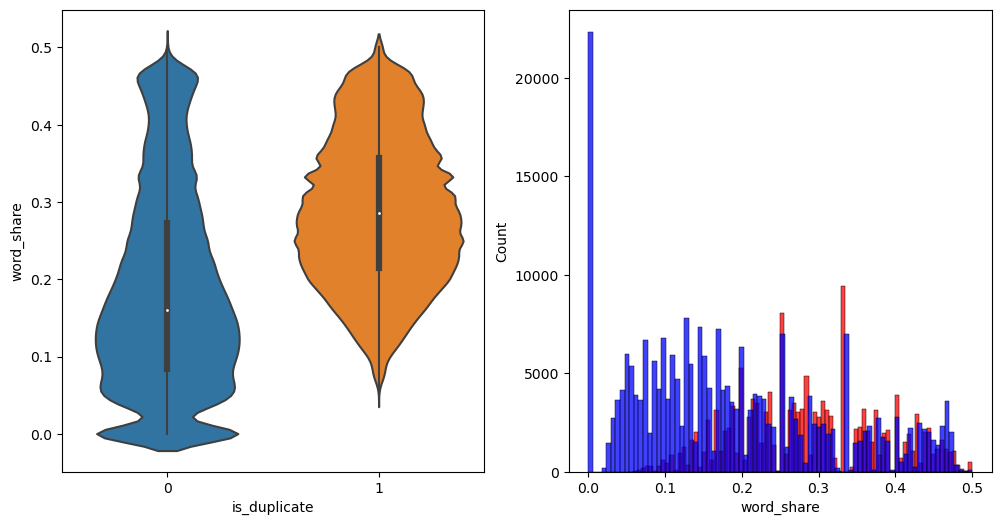

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.histplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue')
plt.show()

<h4> 3.3.4.2 Feature: word_Common </h4>

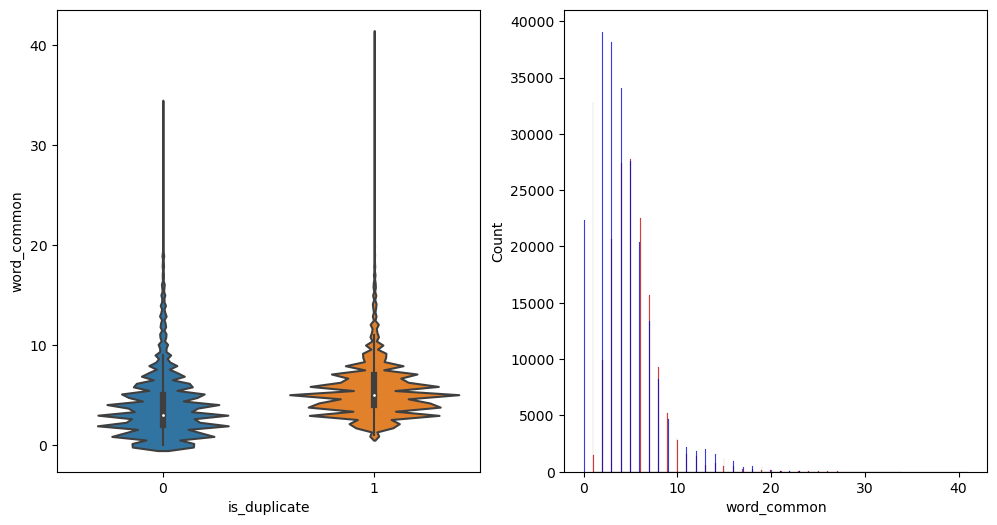

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['word_common'][0:] , label = "1", color = 'red')
sns.histplot(df[df['is_duplicate'] == 0.0]['word_common'][0:] , label = "0" , color = 'blue' )
plt.show()

<h2> 3.5 : EDA: Advanced Feature Extraction.</h2>

<h3> 3.5.1 Preprocessing of Text </h3>

<ol>
<li>
<b>Removing HTML Tags:</b>
    When dealing with text data obtained from web pages, it often contains HTML tags that are used for formatting and styling. Removing these tags ensures that only the actual text content is considered.
</li>

<li>
<b>Removing Punctuations:</b>
    Punctuation marks (e.g., commas, periods, exclamation marks) don't usually carry much semantic meaning in NLP tasks. Removing them simplifies the text and helps in reducing dimensionality in text data.
</li>

<li>
<b>Performing Stemming:</b>
    Stemming involves reducing words to their root or base form. For example, "running" becomes "run." This is done to consolidate words with the same base meaning, reducing the vocabulary size and improving model efficiency.
</li>

<li>
<b>Removing Stopwords:</b>
    Stopwords are common words (e.g., "the," "and," "is") that don't contribute much to the meaning of a text. Removing them helps in focusing on the more meaningful words for analysis.
</li>

<li>
<b>Expanding Contractions:</b>
    Contractions are shortened forms of words (e.g., "don't" for "do not"). Expanding contractions ensures that each word is treated as a separate token, helping the model better understand the text.
</li>

In [21]:
def preprocess_text(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Expand contractions
    text = contractions.fix(text)

    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    text = ' '.join(filtered_words)

    # Perform stemming
    porter = PorterStemmer()
    words = word_tokenize(text)
    stemmed_words = [porter.stem(word) for word in words]
    text = ' '.join(stemmed_words)

    return text

# Apply tqdm to the DataFrame processing
tqdm.pandas()

# Convert text in 'question1' and 'question2' columns to lowercase
df['question1'] = df['question1'].str.lower()
df['question2'] = df['question2'].str.lower()

# Apply the preprocessing function to 'question1' and 'question2' columns
df['question1'] = df['question1'].progress_apply(preprocess_text)
df['question2'] = df['question2'].progress_apply(preprocess_text)

100%|██████████| 404287/404287 [04:58<00:00, 1353.88it/s]


<h2> 3.6 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [22]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    SAFE_DIV = 0.0001 
    stop_words = set(stopwords.words('english'))

    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in stop_words])
    q2_words = set([word for word in q2_tokens if word not in stop_words])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in stop_words])
    q2_stops = set([word for word in q2_tokens if word in stop_words])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both questions is same or not
    if q1_tokens and q2_tokens:
        token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    else:
        token_features[6] = 0  # or any default value you prefer


    # First word of both question is same or not
    if q1_tokens and q2_tokens:
        token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    else:
        token_features[7] = 0  # or any default value you prefer

    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2

    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    token_features = list(tqdm(df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1), desc="Processing rows", total=len(df)))
    
    df["cwc_min"] = list(map(lambda x: x[0], token_features))
    df["cwc_max"] = list(map(lambda x: x[1], token_features))
    df["csc_min"] = list(map(lambda x: x[2], token_features))
    df["csc_max"] = list(map(lambda x: x[3], token_features))
    df["ctc_min"] = list(map(lambda x: x[4], token_features))
    df["ctc_max"] = list(map(lambda x: x[5], token_features))
    df["last_word_eq"] = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"] = list(map(lambda x: x[8], token_features))
    df["mean_len"] = list(map(lambda x: x[9], token_features))

    # Computing Fuzzy Features and Merging with Dataset
    df["token_set_ratio"] = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"] = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"] = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"] = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"] = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    return df

df = extract_features(df)
df.head()

Processing rows: 100%|██████████| 404287/404287 [00:00<00:00, 2888814.92it/s]


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,1,1,66,57,...,0.714276,0,1,0.0,6.5,100,92,92,100,0.971429
1,1,3,4,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...,0,4,1,51,88,...,0.222220,0,0,0.0,6.5,84,62,62,94,0.812500
2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dn,0,1,1,73,59,...,0.499992,0,0,0.0,5.5,85,74,56,60,0.290323
3,3,7,8,mental lone solv,find remaind math2324math divid 2423,0,1,1,50,65,...,0.000000,0,0,0.0,4.0,23,23,23,25,0.058824
4,4,9,10,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,0,3,1,76,39,...,0.199998,0,0,0.0,7.5,53,42,42,50,0.206897


<h3>3.6.1 Analysis of extracted features </h3>

<h4> 3.6.1.1 Plotting Word clouds</h4>

In [23]:
df_duplicate = df[df['is_duplicate']==1]
df_not_duplicate = df[df['is_duplicate']==0]

all_duplicate_question = np.dstack([df_duplicate['question1'], df_duplicate['question2']]).flatten()
all_not_duplicate_question = np.dstack([df_not_duplicate['question1'], df_not_duplicate['question2']]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(all_duplicate_question))
print ("Number of data points in class 0 (non duplicate pairs) :",len(all_not_duplicate_question))

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510048


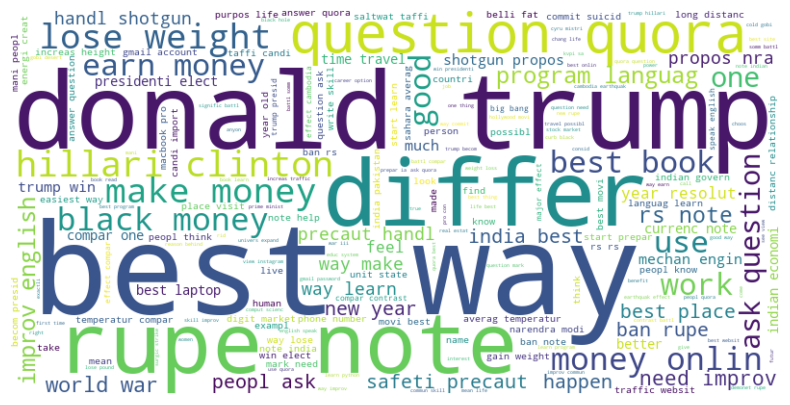

In [24]:
# Combine the sentences into a single string
text = " ".join(all_duplicate_question)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

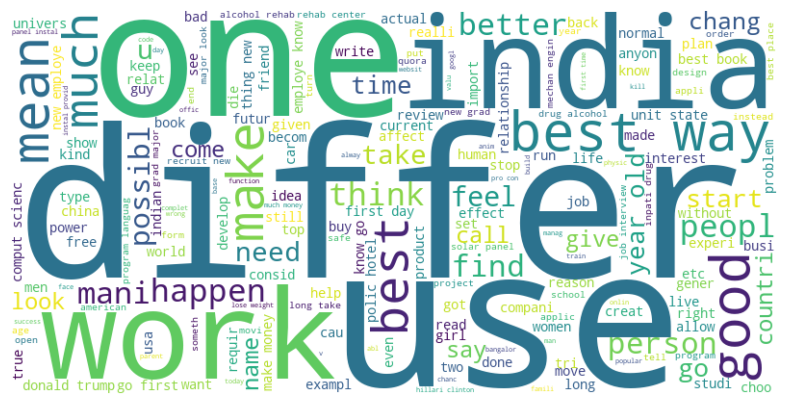

In [25]:
# Combine the sentences into a single string
text = " ".join(all_not_duplicate_question)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<h4> 3.6.1.2 Plotting pair plot</h4>

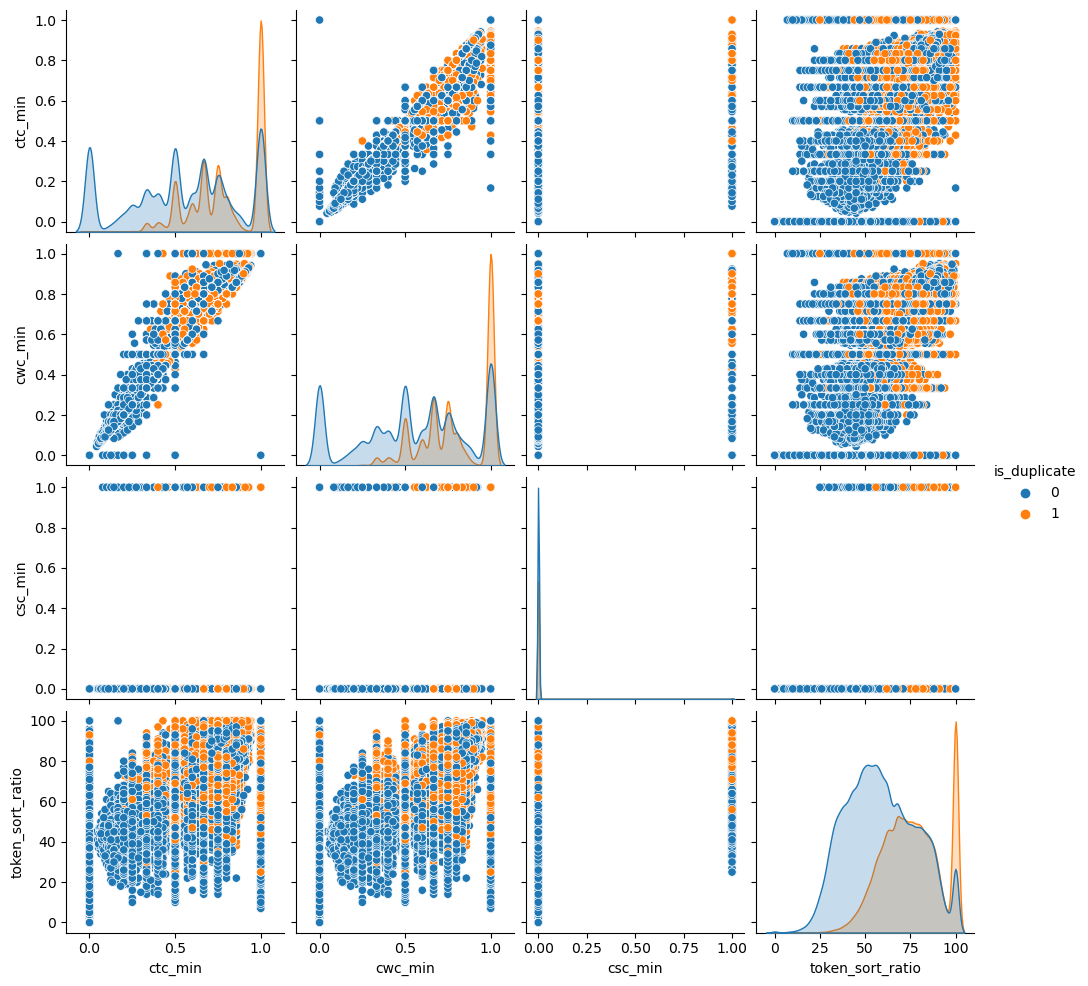

In [26]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

<h4> 3.6.1.3 Plotting violin plot with histogram</h4>

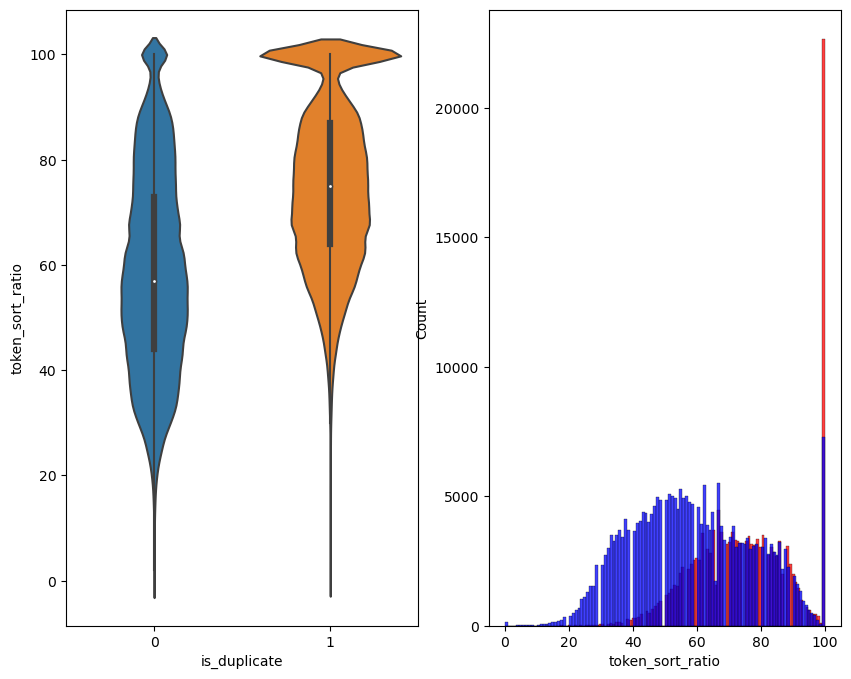

In [27]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.histplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

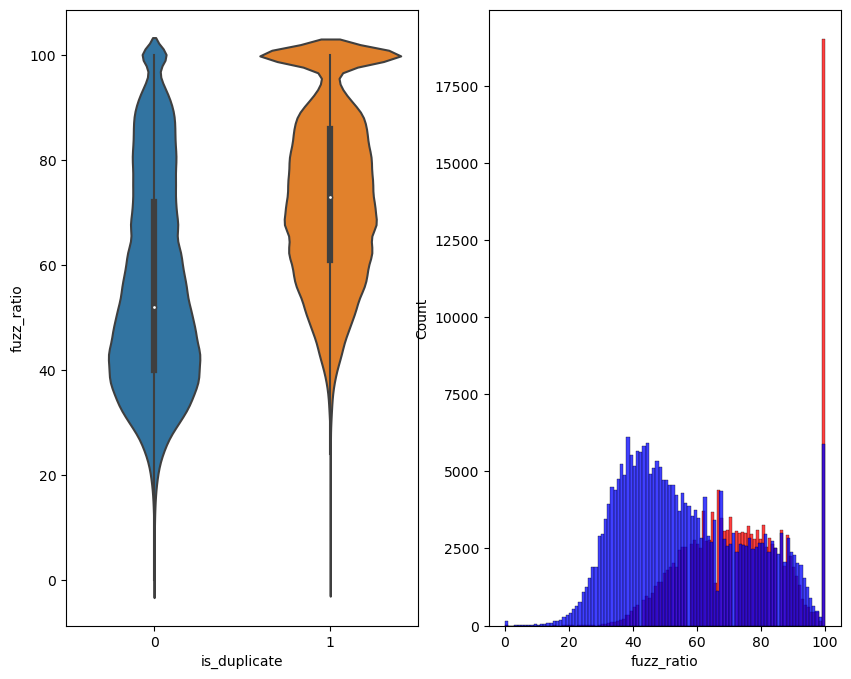

In [28]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.histplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h4> 3.6.1. Preprocessing the text</h4>

In [29]:
# Step 1: Identify rows with empty values
empty_rows = df.applymap(lambda x: len(str(x).strip()) == 0 or str(x).strip().lower() == 'null').any(axis=1)

# Step 2: Drop the rows with empty values
df = df[~empty_rows]

# Step 3: Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

In [30]:
df.to_csv('preprocessed_data.csv', index=False)

In [32]:
try:
    df = pd.read_csv('preprocessed_data.csv')
except FileNotFoundError:
    print("Please check the path of CSV file.")
else:
    print("Succesfully load the data")

Succesfully load the data


In [33]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,1,1,66,57,...,0.714276,0,1,0.0,6.5,100,92,92,100,0.971429
1,1,3,4,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...,0,4,1,51,88,...,0.222220,0,0,0.0,6.5,84,62,62,94,0.812500
2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dn,0,1,1,73,59,...,0.499992,0,0,0.0,5.5,85,74,56,60,0.290323
3,3,7,8,mental lone solv,find remaind math2324math divid 2423,0,1,1,50,65,...,0.000000,0,0,0.0,4.0,23,23,23,25,0.058824
4,4,9,10,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,0,3,1,76,39,...,0.199998,0,0,0.0,7.5,53,42,42,50,0.206897


In [34]:
print(f"we have {df.shape[0]} rows and {df.shape[1]} columns. ")

we have 404155 rows and 32 columns. 


In [35]:
X = df.drop(['is_duplicate'], axis=1)
Y = df['is_duplicate']

<h1> 4. Prepare dataset for Model building  </h1>

<h2>4.1 Splitting the data into Train, cv, Test</h2>

In [36]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [37]:
print('Number of data points in train data:', X_train.shape)
print('Number of data points in test data:', X_test.shape)
print('Number of data points in cross validation data:', X_cv.shape)

Number of data points in train data: (258659, 31)
Number of data points in test data: (80831, 31)
Number of data points in cross validation data: (64665, 31)


In [38]:
X_train_questions_df = X_train[['question1', 'question2']]
X_train_numeric_df   = X_train.drop(['question1', 'question2'], axis=1)

X_test_questions_df  = X_test[['question1', 'question2']]
X_test_numeric_df    = X_test.drop(['question1', 'question2'], axis=1)

X_cv_questions_df    = X_cv[['question1', 'question2']]
X_cv_numeric_df      = X_cv.drop(['question1', 'question2'], axis=1)

<h2> 4.2 Text featurization</h2>

<h3> 4.2.1 Bow featurization </h3>

In [39]:
# Create a CountVectorizer instance with a maximum of 3000 features
bow_vectorizer = CountVectorizer(max_features=3000)

# Combine question1 and question2 columns from training dataset
X_train_questions = list(X_train_questions_df['question1']) + list(X_train_questions_df['question2'])
# Combine question1 and question2 columns from test dataset
X_test_questions  = list(X_test_questions_df['question1']) + list(X_test_questions_df['question2'])
# Combine question1 and question2 columns from cross-validation dataset
X_cv_questions    = list(X_cv_questions_df['question1']) + list(X_cv_questions_df['question2'])

# Transform the combined text data into bag-of-words representation for training data
X_train_q1_arr, X_train_q2_arr = np.vsplit(bow_vectorizer.fit_transform(X_train_questions).toarray(), 2)
# Create DataFrames from the transformed arrays with original indices and feature names
X_train_q1_df1 = pd.DataFrame(X_train_q1_arr, index=X_train_questions_df.index, columns=bow_vectorizer.get_feature_names_out())
X_train_q1_df2 = pd.DataFrame(X_train_q2_arr, index=X_train_questions_df.index, columns=bow_vectorizer.get_feature_names_out())
# Concatenate the created DataFrames along the columns
X_train_bow_questions_df = pd.concat([X_train_q1_df1, X_train_q1_df2], axis=1)
# Concatenate bag-of-words representation with numeric features for training data
X_train_bow = pd.concat([X_train_numeric_df, X_train_bow_questions_df], axis=1)

# Transform the combined text data into bag-of-words representation for test data
X_test_q1_arr, X_test_q2_arr = np.vsplit(bow_vectorizer.transform(X_test_questions).toarray(), 2)
# Create DataFrames from the transformed arrays with original indices and feature names
X_test_q1_df1 = pd.DataFrame(X_test_q1_arr, index=X_test_questions_df.index, columns=bow_vectorizer.get_feature_names_out())
X_test_q1_df2 = pd.DataFrame(X_test_q2_arr, index=X_test_questions_df.index, columns=bow_vectorizer.get_feature_names_out())
# Concatenate the created DataFrames along the columns
X_test_bow_questions_df = pd.concat([X_test_q1_df1, X_test_q1_df2], axis=1)
# Concatenate bag-of-words representation with numeric features for test data
X_test_bow = pd.concat([X_test_numeric_df, X_test_bow_questions_df], axis=1)

# Transform the combined text data into bag-of-words representation for cross-validation data
X_cv_q1_arr, X_cv_q2_arr = np.vsplit(bow_vectorizer.transform(X_cv_questions).toarray(), 2)
# Create DataFrames from the transformed arrays with original indices and feature names
X_cv_q1_df1 = pd.DataFrame(X_cv_q1_arr, index=X_cv_questions_df.index, columns=bow_vectorizer.get_feature_names_out())
X_cv_q1_df2 = pd.DataFrame(X_cv_q2_arr, index=X_cv_questions_df.index, columns=bow_vectorizer.get_feature_names_out())
# Concatenate the created DataFrames along the columns
X_cv_bow_questions_df = pd.concat([X_cv_q1_df1, X_cv_q1_df2], axis=1)
# Concatenate bag-of-words representation with numeric features for cross-validation data
X_cv_bow = pd.concat([X_cv_numeric_df, X_cv_bow_questions_df], axis=1)

In [40]:
print("Total no of features we have generated using BOW is: ", 2*len(bow_vectorizer.get_feature_names_out()))
print('Number of data points in train data:', X_train_bow.shape)
print('Number of data points in test data:', X_test_bow.shape)
print('Number of data points in cross validation data:', X_cv_bow.shape)

Total no of features we have generated using BOW is:  6000
Number of data points in train data: (258659, 6029)
Number of data points in test data: (80831, 6029)
Number of data points in cross validation data: (64665, 6029)


<h3> 4.2.2 TF-IDF featurization </h3>

In [43]:
# Create a TF-IDF Vectorizer instance with a maximum of 3000 features
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Combine question1 and question2 columns from the training dataset
X_train_questions = list(X_train_questions_df['question1']) + list(X_train_questions_df['question2'])
# Combine question1 and question2 columns from the test dataset
X_test_questions  = list(X_test_questions_df['question1']) + list(X_test_questions_df['question2'])
# Combine question1 and question2 columns from the cross-validation dataset
X_cv_questions    = list(X_cv_questions_df['question1']) + list(X_cv_questions_df['question2'])

# Transform the combined text data into TF-IDF representation for the training data
X_train_q1_arr, X_train_q2_arr = np.vsplit(tfidf_vectorizer.fit_transform(X_train_questions).toarray(), 2)
# Create DataFrames from the transformed arrays with original indices and feature names
X_train_q1_df1 = pd.DataFrame(X_train_q1_arr, index=X_train_questions_df.index, columns=tfidf_vectorizer.get_feature_names_out())
X_train_q1_df2 = pd.DataFrame(X_train_q2_arr, index=X_train_questions_df.index, columns=tfidf_vectorizer.get_feature_names_out())
# Concatenate the created DataFrames along the columns
X_train_tfidf_questions_df = pd.concat([X_train_q1_df1, X_train_q1_df2], axis=1)
# Concatenate TF-IDF representation with numeric features for training data
X_train_tfidf = pd.concat([X_train_numeric_df, X_train_tfidf_questions_df], axis=1)

# Transform the combined text data into TF-IDF representation for the test data
X_test_q1_arr, X_test_q2_arr = np.vsplit(tfidf_vectorizer.transform(X_test_questions).toarray(), 2)
# Create DataFrames from the transformed arrays with original indices and feature names
X_test_q1_df1 = pd.DataFrame(X_test_q1_arr, index=X_test_questions_df.index, columns=tfidf_vectorizer.get_feature_names_out())
X_test_q1_df2 = pd.DataFrame(X_test_q2_arr, index=X_test_questions_df.index, columns=tfidf_vectorizer.get_feature_names_out())
# Concatenate the created DataFrames along the columns
X_test_tfidf_questions_df = pd.concat([X_test_q1_df1, X_test_q1_df2], axis=1)
# Concatenate TF-IDF representation with numeric features for test data
X_test_tfidf = pd.concat([X_test_numeric_df, X_test_tfidf_questions_df], axis=1)

# Transform the combined text data into TF-IDF representation for the cross-validation data
X_cv_q1_arr, X_cv_q2_arr = np.vsplit(tfidf_vectorizer.transform(X_cv_questions).toarray(), 2)
# Create DataFrames from the transformed arrays with original indices and feature names
X_cv_q1_df1 = pd.DataFrame(X_cv_q1_arr, index=X_cv_questions_df.index, columns=tfidf_vectorizer.get_feature_names_out())
X_cv_q1_df2 = pd.DataFrame(X_cv_q2_arr, index=X_cv_questions_df.index, columns=tfidf_vectorizer.get_feature_names_out())
# Concatenate the created DataFrames along the columns
X_cv_tfidf_questions_df = pd.concat([X_cv_q1_df1, X_cv_q1_df2], axis=1)
# Concatenate TF-IDF representation with numeric features for cross-validation data
X_cv_tfidf = pd.concat([X_cv_numeric_df, X_cv_tfidf_questions_df], axis=1)

MemoryError: Unable to allocate 3.85 GiB for an array with shape (517318, 1000) and data type float64

In [ ]:
print("Total no of features we have generated using BOW is: ", 2*len(tfidf_vectorizer.get_feature_names_out()))
print('Number of data points in train data:', X_train_tfidf.shape)
print('Number of data points in test data:', X_test_tfidf.shape)
print('Number of data points in cross validation data:', X_cv_tfidf.shape)

<h3> 4.2.3 W2V featurization </h3>

In [ ]:
# Combine questions for training, testing, and cross-validation sets
X_train_questions = list(X_train_questions_df['question1']) + list(X_train_questions_df['question2'])
X_test_questions  = list(X_test_questions_df['question1']) + list(X_test_questions_df['question2'])
X_cv_questions    = list(X_cv_questions_df['question1']) + list(X_cv_questions_df['question2'])

# Tokenize the sentences into words
X_train_tokens = [nltk.word_tokenize(sent) for sent in X_train_questions]
X_test_tokens = [nltk.word_tokenize(sent) for sent in X_test_questions]
X_cv_tokens = [nltk.word_tokenize(sent) for sent in X_cv_questions]

# Create Word2Vec model
w2v_model = Word2Vec(sentences=X_train_tokens + X_test_tokens + X_cv_tokens, vector_size=300, window=5, min_count=1, workers=4)

# Function to convert a sentence to the average Word2Vec representation
def sentence_to_avg_w2v(sentence, model):
    words = word_tokenize(sentence)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        # If none of the words in the sentence are in the vocabulary
        return np.zeros(model.vector_size)

# Convert questions to Word2Vec representations for training data
X_train_w2v_arr = np.array([sentence_to_avg_w2v(sentence, w2v_model) for sentence in X_train_questions])
X_train_q1_arr, X_train_q2_arr = np.vsplit(X_train_w2v_arr, 2)
X_train_q1_df1 = pd.DataFrame(X_train_q1_arr, index=X_train_questions_df.index)
X_train_q1_df2 = pd.DataFrame(X_train_q2_arr, index=X_train_questions_df.index)
X_train_w2v_questions_df = pd.concat([X_train_q1_df1, X_train_q1_df2], axis=1)
X_train_w2v = pd.concat([X_train_numeric_df, X_train_w2v_questions_df], axis=1)

# Convert questions to Word2Vec representations for test data
X_test_w2v_arr = np.array([sentence_to_avg_w2v(sentence, w2v_model) for sentence in X_test_questions])
X_test_q1_arr, X_test_q2_arr = np.vsplit(X_test_w2v_arr, 2)
X_test_q1_df1 = pd.DataFrame(X_test_q1_arr, index=X_test_questions_df.index)
X_test_q1_df2 = pd.DataFrame(X_test_q2_arr, index=X_test_questions_df.index)
X_test_w2v_questions_df = pd.concat([X_test_q1_df1, X_test_q1_df2], axis=1)
X_test_w2v = pd.concat([X_test_numeric_df, X_test_w2v_questions_df], axis=1)

# Convert questions to Word2Vec representations for cross-validation data
X_cv_w2v_arr = np.array([sentence_to_avg_w2v(sentence, w2v_model) for sentence in X_cv_questions])
X_cv_q1_arr, X_cv_q2_arr = np.vsplit(X_cv_w2v_arr, 2)
X_cv_q1_df1 = pd.DataFrame(X_cv_q1_arr, index=X_cv_questions_df.index)
X_cv_q1_df2 = pd.DataFrame(X_cv_q2_arr, index=X_cv_questions_df.index)
X_cv_w2v_questions_df = pd.concat([X_cv_q1_df1, X_cv_q1_df2], axis=1)
X_cv_w2v = pd.concat([X_cv_numeric_df, X_cv_w2v_questions_df], axis=1)

In [ ]:
print('Number of data points in train data:', X_train_w2v.shape)
print('Number of data points in test data:', X_test_w2v.shape)
print('Number of data points in cross validation data:', X_cv_w2v.shape)

<h3> 4.2.4 TF-IDF W2V featurization </h3>

<h2> 4.3 Model building </h2>

<h3> 4.3.1 Model performance visualize</h3>

In [ ]:
# Define a function to evaluate the performance of a classification model
def model_performance_metrics(y_test, y_pred):
    # Print a separator line for better visibility
    print("*" * 15 + "Performance metric" + "*" * 15)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    # Calculate the confusion matrix
    C = confusion_matrix(y_test, y_pred)
    
    # Calculate precision matrix by normalizing each column of the confusion matrix
    A = (((C.T) / (C.sum(axis=1))).T)
    
    # Calculate recall matrix by normalizing each row of the confusion matrix
    B = (C / C.sum(axis=0))
    
    # Define class labels
    labels = [1, 2]
    
    # Plot confusion matrix heatmap
    print("-" * 20, "Confusion matrix", "-" * 20)
    plt.figure(figsize=(3, 3))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # Print and plot precision matrix
    print("-" * 20, "Precision matrix (Column Sum=1)", "-" * 20)
    precision = precision_score(y_test, y_pred)
    print(f"Precision: {precision:.4f}")
    plt.figure(figsize=(3, 3))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # Print and plot recall matrix
    print("-" * 20, "Recall matrix (Row Sum=1)", "-" * 20)
    recall = recall_score(y_test, y_pred)
    print(f"Recall: {recall:.4f}")
    plt.figure(figsize=(3, 3))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # Print F1 Score
    print("-" * 20, "F1 Score", "-" * 20)
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")
    
    # Return calculated metrics
    return accuracy, precision, recall, f1

<h3>4.3.2 KNN Algorithm</h3>

In [ ]:
def knn_model(X_train, y_train, X_cv, y_cv, X_test, y_test, k_list):
    # Step 1: Define a list of even values for k up to max_k
    k_values = k_list
    # Initialize an array to store log loss for each value of k
    cv_log_error_array = []

    # Step 2: Loop through each value of k
    for k in k_values:
        # Initialize KNN classifier with the current value of k
        knn = KNeighborsClassifier(n_neighbors=k)
        # Fit the KNN model on the training data
        knn.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_knn = CalibratedClassifierCV(knn, method="sigmoid")
        sig_clf_knn.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_knn.predict_proba(X_cv)

        # Calculate log loss and append to the array
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs_cv, labels=knn.classes_, eps=1e-15))

        # Print log loss for the current value of k
        print('For value of k =', k, 'The log loss is:', log_loss(y_cv, sig_clf_probs_cv))

    # Step 3: Plot the cross-validation error for each value of k
    fig, ax = plt.subplots()
    ax.plot(k_values, cv_log_error_array, c='g')
    for i, txt in enumerate(np.round(cv_log_error_array, 3)):
        ax.annotate((k_values[i], np.round(txt, 3)), (k_values[i], cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each k")
    plt.xlabel("K (Number of Neighbors)")
    plt.ylabel("Log Loss")
    plt.show()
    
    # Step 4: Identify the best k based on minimum log loss
    best_k = k_values[np.argmin(cv_log_error_array)]
    best_knn = KNeighborsClassifier(n_neighbors=best_k)
    best_knn.fit(X_train, y_train)

    # Calibrate the best model using sigmoid calibration
    best_sig_clf_knn = CalibratedClassifierCV(best_knn, method="sigmoid")
    best_sig_clf_knn.fit(X_train, y_train)

    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_knn.predict_proba(X_train)
    knn_train_log_loss = log_loss(y_train, predict_y_train, labels=best_knn.classes_, eps=1e-15)
    # Print log loss on the training set for the best model
    print('For values of best k =', best_k, "The train log loss is:", knn_train_log_loss)

    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_sig_clf_knn.predict_proba(X_cv)
    knn_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_knn.classes_, eps=1e-15)
    # Print log loss on the cross-validation set for the best model
    print('For values of best k =', best_k, "The cv log loss is:", knn_cv_log_loss)

    # Predict probabilities on the test set for the best model
    predict_y_test = best_sig_clf_knn.predict_proba(X_test)
    knn_test_log_loss = log_loss(y_test, predict_y_test, labels=best_knn.classes_, eps=1e-15)
    # Print log loss on the test set for the best model
    print('For values of best k =', best_k, "The test log loss is:", knn_test_log_loss)
    
    # Calculate and print the number of misclassified points
    predict_y = best_sig_clf_knn.predict(X_test)
    knn_misclassified_points = np.count_nonzero((predict_y - y_test) != 0) / y_test.shape[0]
    print("Number of misclassified points:", knn_misclassified_points)

    
    # Print additional model performance metrics
    knn_accuracy, knn_precision, knn_recall, knn_f1 = model_performance_metrics(y_test, predict_y)
    
    return knn_accuracy, knn_precision, knn_recall, knn_f1, knn_train_log_loss, knn_cv_log_loss, knn_test_log_loss, knn_misclassified_points

In [ ]:
# X_train_bow, y_train, X_cv_bow, y_cv, X_test_bow, y_test are defined earlier
knn_bow_accuracy, knn_bow_precision, knn_bow_recall, knn_bow_f1, knn_bow_train_log_loss, knn_bow_cv_log_loss, knn_bow_test_log_loss, knn_bow_misclassified_points = knn_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, [2, 4, 6, 8])

In [ ]:
# X_train_tfidf, y_train, X_cv_tfidf, y_cv, X_test_tfidf, y_test are defined earlier
knn_tfidf_accuracy, knn_tfidf_precision, knn_tfidf_recall, knn_tfidf_f1, knn_tfidf_train_log_loss, knn_tfidf_cv_log_loss, knn_tfidf_test_log_loss, knn_tfidf_misclassified_points = knn_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, [2, 4, 6, 8])

In [ ]:
# X_train_w2v, y_train, X_cv_w2v, y_cv, X_test_w2v, y_test are defined earlier
knn_w2v_accuracy, knn_w2v_precision, knn_w2v_recall, knn_w2v_f1, knn_w2v_train_log_loss, knn_w2v_cv_log_loss, knn_w2v_test_log_loss, knn_w2v_misclassified_points = knn_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, [2, 4, 6, 8])

In [ ]:
<h3>4.3.3 Multinomial Naive bayes Algorithm</h3>

In [ ]:
def mnb_model(X_train, y_train, X_cv, y_cv, X_test, y_test, alpha_values):
    # Step 1: Define a list of alpha values
    alpha_list = alpha_values
    # Initialize an array to store log loss for each value of alpha
    cv_log_error_array = []

    # Step 2: Loop through each value of alpha
    for alpha in alpha_list:
        # Initialize Multinomial Naive Bayes classifier with the current value of alpha
        mnb = MultinomialNB(alpha=alpha)
        # Fit the Multinomial Naive Bayes model on the training data
        mnb.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_mnb = CalibratedClassifierCV(mnb, method="sigmoid")
        sig_clf_mnb.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_mnb.predict_proba(X_cv)

        # Calculate log loss and append to the array
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs_cv, labels=mnb.classes_))

        # Print log loss for the current value of alpha
        print('For value of alpha =', alpha, 'The log loss is:', log_loss(y_cv, sig_clf_probs_cv))

    # Step 3: Plot the cross-validation error for each value of alpha
    fig, ax = plt.subplots()
    ax.plot(alpha_list, cv_log_error_array, c='g')
    for i, txt in enumerate(np.round(cv_log_error_array, 3)):
        ax.annotate((alpha_list[i], np.round(txt, 3)), (alpha_list[i], cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha (Smoothing Parameter)")
    plt.ylabel("Log Loss")
    plt.show()

    # Step 4: Identify the best alpha based on minimum log loss
    best_alpha = alpha_list[np.argmin(cv_log_error_array)]
    best_mnb = MultinomialNB(alpha=best_alpha)
    best_mnb.fit(X_train, y_train)

    # Calibrate the best model using sigmoid calibration
    best_sig_clf_mnb = CalibratedClassifierCV(best_mnb, method="sigmoid")
    best_sig_clf_mnb.fit(X_train, y_train)

    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_mnb.predict_proba(X_train)
    mnb_train_log_loss = log_loss(y_train, predict_y_train, labels=best_mnb.classes_)
    # Print log loss on the training set for the best model
    print('For values of best alpha =', best_alpha, "The train log loss is:", mnb_train_log_loss)

    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_sig_clf_mnb.predict_proba(X_cv)
    mnb_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_mnb.classes_)
    # Print log loss on the cross-validation set for the best model
    print('For values of best alpha =', best_alpha, "The cv log loss is:", mnb_cv_log_loss)

    # Predict probabilities on the test set for the best model
    predict_y_test = best_sig_clf_mnb.predict_proba(X_test)
    mnb_test_log_loss = log_loss(y_test, predict_y_test, labels=best_mnb.classes_)
    # Print log loss on the test set for the best model
    print('For values of best alpha =', best_alpha, "The test log loss is:", mnb_test_log_loss)

    # Calculate and print the number of misclassified points
    predict_y = best_sig_clf_mnb.predict(X_test)
    mnb_misclassified_points = np.count_nonzero((predict_y - y_test) != 0) / y_test.shape[0]
    print("Number of misclassified points:", mnb_misclassified_points)

    # Print additional model performance metrics
    mnb_accuracy, mnb_precision, mnb_recall, mnb_f1 = model_performance_metrics(y_test, predict_y)
    
    return mnb_accuracy, mnb_precision, mnb_recall, mnb_f1, mnb_train_log_loss, mnb_cv_log_loss, mnb_test_log_loss, mnb_misclassified_points

In [ ]:
# Assuming X_train_bow, y_train, X_cv_bow, y_cv, X_test_bow, y_test are defined earlier
mnb_bow_accuracy, mnb_bow_precision, mnb_bow_recall, mnb_bow_f1, mnb_bow_train_log_loss, mnb_bow_cv_log_loss, mnb_bow_test_log_loss, mnb_bow_misclassified_points = mnb_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, [0.1, 0.5, 1.0, 2.0])

In [ ]:
# Assuming X_train_tfidf, y_train, X_cv_tfidf, y_cv, X_test_tfidf, y_test are defined earlier
mnb_tfidf_accuracy, mnb_tfidf_precision, mnb_tfidf_recall, mnb_tfidf_f1, mnb_tfidf_train_log_loss, mnb_tfidf_cv_log_loss, mnb_tfidf_test_log_loss, mnb_tfidf_misclassified_points = mnb_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, [0.1, 0.5, 1.0, 2.0])

In [ ]:
# mnb_w2v_accuracy, mnb_w2v_precision, mnb_w2v_recall, mnb_w2v_f1, mnb_w2v_train_log_loss, mnb_w2v_cv_log_loss, mnb_w2v_test_log_loss, mnb_w2v_misclassified_points = mnb_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, [0.1, 0.5, 1.0, 2.0])

<h3>4.3.4 Logistic Regression Algorithm</h3>

In [ ]:
def logistic_regression_sgd_model(X_train, y_train, X_cv, y_cv, X_test, y_test, alpha_values):
    # Step 1: Define a list of alpha values
    alpha_list = alpha_values
    # Initialize an array to store log loss for each value of alpha
    cv_log_error_array = []

    # Step 2: Loop through each value of alpha
    for alpha in alpha_list:
        # Initialize Logistic Regression with SGD classifier with the current value of alpha
        log_reg_sgd = SGDClassifier(loss='log_loss', alpha=alpha)
        # Fit the Logistic Regression with SGD model on the training data
        log_reg_sgd.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_log_reg_sgd = CalibratedClassifierCV(log_reg_sgd, method="sigmoid")
        sig_clf_log_reg_sgd.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_log_reg_sgd.predict_proba(X_cv)

        # Calculate log loss and append to the array
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs_cv, labels=log_reg_sgd.classes_))

        # Print log loss for the current value of alpha
        print('For value of alpha =', alpha, 'The log loss is:', log_loss(y_cv, sig_clf_probs_cv))

    # Step 3: Plot the cross-validation error for each value of alpha
    fig, ax = plt.subplots()
    ax.plot(alpha_list, cv_log_error_array, c='g')
    for i, txt in enumerate(np.round(cv_log_error_array, 3)):
        ax.annotate((alpha_list[i], np.round(txt, 3)), (alpha_list[i], cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha (Regularization Parameter)")
    plt.ylabel("Log Loss")
    plt.show()

    # Step 4: Identify the best alpha based on minimum log loss
    best_alpha = alpha_list[np.argmin(cv_log_error_array)]
    best_log_reg_sgd = SGDClassifier(loss='log_loss', alpha=best_alpha)
    best_log_reg_sgd.fit(X_train, y_train)

    # Calibrate the best model using sigmoid calibration
    best_sig_clf_log_reg_sgd = CalibratedClassifierCV(best_log_reg_sgd, method="sigmoid")
    best_sig_clf_log_reg_sgd.fit(X_train, y_train)

    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_log_reg_sgd.predict_proba(X_train)
    log_reg_sgd_train_log_loss = log_loss(y_train, predict_y_train, labels=best_log_reg_sgd.classes_)
    # Print log loss on the training set for the best model
    print('For values of best alpha =', best_alpha, "The train log loss is:", log_loss(y_train, predict_y_train, labels=best_log_reg_sgd.classes_))

    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_sig_clf_log_reg_sgd.predict_proba(X_cv)
    log_reg_sgd_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_log_reg_sgd.classes_)
    # Print log loss on the cross-validation set for the best model
    print('For values of best alpha =', best_alpha, "The cv log loss is:", log_reg_sgd_train_log_loss)

    # Predict probabilities on the test set for the best model
    predict_y_test = best_sig_clf_log_reg_sgd.predict_proba(X_test)
    log_reg_sgd_test_log_loss = log_loss(y_test, predict_y_test, labels=best_log_reg_sgd.classes_)
    # Print log loss on the test set for the best model
    print('For values of best alpha =', best_alpha, "The test log loss is:", log_reg_sgd_test_log_loss)

    # Calculate and print the number of misclassified points
    predict_y = best_sig_clf_log_reg_sgd.predict(X_test)
    log_reg_sgd_misclassified_points =  np.count_nonzero((predict_y - y_test) != 0) / y_test.shape[0]
    print("Number of misclassified points:", log_reg_sgd_misclassified_points)

    # Print additional model performance metrics
    log_reg_sgd_accuracy, log_reg_sgd_precision, log_reg_sgd_recall, log_reg_sgd_f1 = model_performance_metrics(y_test, predict_y)
    
    return log_reg_sgd_accuracy, log_reg_sgd_precision, log_reg_sgd_recall, log_reg_sgd_f1, log_reg_sgd_train_log_loss, log_reg_sgd_cv_log_loss, log_reg_sgd_test_log_loss, log_reg_sgd_misclassified_points

In [ ]:
# Assuming X_train_bow, y_train, X_cv_bow, y_cv, X_test_bow, y_test are defined earlier
log_reg_sgd_bow_accuracy, log_reg_sgd_bow_precision, log_reg_sgd_bow_recall, log_reg_sgd_bow_f1, log_reg_sgd_bow_train_log_loss, log_reg_sgd_bow_cv_log_loss, log_reg_sgd_bow_test_log_loss, log_reg_sgd_bow_misclassified_points = logistic_regression_sgd_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, [0.0001, 0.001, 0.01, 0.1])

In [ ]:
# Assuming X_train_tfidf, y_train, X_cv_tfidf, y_cv, X_test_tfidf, y_test are defined earlier
log_reg_sgd_tfidf_accuracy, log_reg_sgd_tfidf_precision, log_reg_sgd_tfidf_recall, log_reg_sgd_tfidf_f1, log_reg_sgd_tfidf_train_log_loss, log_reg_sgd_tfidf_cv_log_loss, log_reg_sgd_tfidf_test_log_loss, log_reg_sgd_tfidf_misclassified_points = logistic_regression_sgd_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, [0.0001, 0.001, 0.01, 0.1])

In [ ]:
# Assuming X_train_w2v, y_train, X_cv_w2v, y_cv, X_test_w2v, y_test are defined earlier
log_reg_sgd_w2v_accuracy, log_reg_sgd_w2v_precision, log_reg_sgd_w2v_recall, log_reg_sgd_w2v_f1, log_reg_sgd_w2v_train_log_loss, log_reg_sgd_w2v_cv_log_loss, log_reg_sgd_w2v_test_log_loss, log_reg_sgd_w2v_misclassified_points = logistic_regression_sgd_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, [0.0001, 0.001, 0.01, 0.1])

<h3>4.3.5 Linear SVM Algorithm</h3>

In [ ]:
def linear_svm_sgd_model(X_train, y_train, X_cv, y_cv, X_test, y_test, alpha_values):
    # Step 1: Define a list of alpha values
    alpha_list = alpha_values
    # Initialize an array to store log loss for each value of alpha
    cv_log_error_array = []

    # Step 2: Loop through each value of alpha
    for alpha in alpha_list:
        # Initialize Linear SVM with SGD classifier with the current value of alpha
        linear_svm_sgd = SGDClassifier(loss='hinge', alpha=alpha, random_state=42)
        # Fit the Linear SVM with SGD model on the training data
        linear_svm_sgd.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_linear_svm_sgd = CalibratedClassifierCV(linear_svm_sgd, method="sigmoid")
        sig_clf_linear_svm_sgd.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_linear_svm_sgd.predict_proba(X_cv)

        # Calculate log loss and append to the array
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs_cv, labels=linear_svm_sgd.classes_))

        # Print log loss for the current value of alpha
        print('For value of alpha =', alpha, 'The log loss is:', log_loss(y_cv, sig_clf_probs_cv))

    # Step 3: Plot the cross-validation error for each value of alpha
    fig, ax = plt.subplots()
    ax.plot(alpha_list, cv_log_error_array, c='g')
    for i, txt in enumerate(np.round(cv_log_error_array, 3)):
        ax.annotate((alpha_list[i], np.round(txt, 3)), (alpha_list[i], cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha (Regularization Parameter)")
    plt.ylabel("Log Loss")
    plt.show()

    # Step 4: Identify the best alpha based on minimum log loss
    best_alpha = alpha_list[np.argmin(cv_log_error_array)]
    best_linear_svm_sgd = SGDClassifier(loss='hinge', alpha=best_alpha, random_state=42)
    best_linear_svm_sgd.fit(X_train, y_train)

    # Calibrate the best model using sigmoid calibration
    best_sig_clf_linear_svm_sgd = CalibratedClassifierCV(best_linear_svm_sgd, method="sigmoid")
    best_sig_clf_linear_svm_sgd.fit(X_train, y_train)

    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_linear_svm_sgd.predict_proba(X_train)
    linear_svm_sgd_train_log_loss = log_loss(y_train, predict_y_train, labels=best_linear_svm_sgd.classes_)
    # Print log loss on the training set for the best model
    print('For values of best alpha =', best_alpha, "The train log loss is:", )

    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_sig_clf_linear_svm_sgd.predict_proba(X_cv)
    linear_svm_sgd_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_linear_svm_sgd.classes_)
    # Print log loss on the cross-validation set for the best model
    print('For values of best alpha =', best_alpha, "The cv log loss is:", )

    # Predict probabilities on the test set for the best model
    predict_y_test = best_sig_clf_linear_svm_sgd.predict_proba(X_test)
    linear_svm_sgd_test_log_loss = log_loss(y_test, predict_y_test, labels=best_linear_svm_sgd.classes_)
    # Print log loss on the test set for the best model
    print('For values of best alpha =', best_alpha, "The test log loss is:", )

    # Calculate and print the number of misclassified points
    predict_y = best_sig_clf_linear_svm_sgd.predict(X_test)
    linear_svm_sgd_misclassified_points = np.count_nonzero((predict_y - y_test) != 0) / y_test.shape[0]
    print("Number of misclassified points:", linear_svm_sgd_misclassified_points)

    # Print additional model performance metrics
    linear_svm_sgd_accuracy, linear_svm_sgd_precision, linear_svm_sgd_recall, linear_svm_sgd_f1 = model_performance_metrics(y_test, predict_y)
    
    return linear_svm_sgd_accuracy, linear_svm_sgd_precision, linear_svm_sgd_recall, linear_svm_sgd_f1, linear_svm_sgd_train_log_loss, linear_svm_sgd_cv_log_loss, linear_svm_sgd_test_log_loss, linear_svm_sgd_misclassified_points

In [ ]:
# Assuming X_train_bow, y_train, X_cv_bow, y_cv, X_test_bow, y_test are defined earlier
linear_svm_sgd_bow_accuracy, linear_svm_sgd_bow_precision, linear_svm_sgd_bow_recall, linear_svm_sgd_bow_f1, linear_svm_sgd_bow_train_log_loss, linear_svm_sgd_bow_cv_log_loss, linear_svm_sgd_bow_test_log_loss, linear_svm_sgd_bow_misclassified_points = linear_svm_sgd_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, [0.0001, 0.001, 0.01, 0.1])

In [ ]:
# Assuming X_train_tfidf, y_train, X_cv_tfidf, y_cv, X_test_tfidf, y_test are defined earlier
linear_svm_sgd_tfidf_accuracy, linear_svm_sgd_tfidf_precision, linear_svm_sgd_tfidf_recall, linear_svm_sgd_tfidf_f1, linear_svm_sgd_tfidf_train_log_loss, linear_svm_sgd_tfidf_cv_log_loss, linear_svm_sgd_tfidf_test_log_loss, linear_svm_sgd_tfidf_misclassified_points = linear_svm_sgd_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, [0.0001, 0.001, 0.01, 0.1])

In [ ]:
# Assuming X_train_w2v, y_train, X_cv_w2v, y_cv, X_test_w2v, y_test are defined earlier
linear_svm_sgd_w2v_accuracy, linear_svm_sgd_w2v_precision, linear_svm_sgd_w2v_recall, linear_svm_sgd_w2v_f1, linear_svm_sgd_w2v_train_log_loss, linear_svm_sgd_w2v_cv_log_loss, linear_svm_sgd_w2v_test_log_loss, linear_svm_sgd_w2v_misclassified_points = linear_svm_sgd_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, [0.0001, 0.001, 0.01, 0.1])

<h3>4.3.6 Decision Tree algorithm</h3>

In [ ]:
def decision_tree_model(X_train, y_train, X_cv, y_cv, X_test, y_test, max_depth_values, min_samples_split_values, min_samples_leaf_values):
    # Initialize arrays to store log loss for each combination of hyperparameters
    cv_log_error_depth = np.zeros(len(max_depth_values))
    cv_log_error_split = np.zeros(len(min_samples_split_values))
    cv_log_error_leaf = np.zeros(len(min_samples_leaf_values))
    cv_log_error_array = np.zeros((len(max_depth_values), len(min_samples_split_values), len(min_samples_leaf_values)))

    # Step 2: Loop through each value of max_depth
    for i, max_depth in enumerate(max_depth_values):
        # Initialize Decision Tree classifier with the current max_depth value
        dtree = DecisionTreeClassifier(max_depth=max_depth)
        # Fit the Decision Tree model on the training data
        dtree.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_dtree = CalibratedClassifierCV(dtree, method="sigmoid")
        sig_clf_dtree.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_dtree.predict_proba(X_cv)
        # Calculate log loss and store in the array
        cv_log_error_depth[i] = log_loss(y_cv, sig_clf_probs_cv, labels=dtree.classes_)

    # Plot the cross-validation error for each value of max_depth
    fig, ax = plt.subplots()
    ax.plot(max_depth_values, cv_log_error_depth, marker='o')
    for i, txt in enumerate(np.round(cv_log_error_depth, 3)):
        ax.annotate((max_depth_values[i], np.round(txt, 3)), (max_depth_values[i], cv_log_error_depth[i]))
    plt.grid()
    plt.xlabel('Max Depth')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of max_depth")
    plt.show()

    # Step 3: Loop through each value of min_samples_split
    for i, min_samples_split in enumerate(min_samples_split_values):
        # Initialize Decision Tree classifier with the current min_samples_split value
        dtree = DecisionTreeClassifier(min_samples_split=min_samples_split)
        dtree.fit(X_train, y_train)
        sig_clf_dtree = CalibratedClassifierCV(dtree, method="sigmoid")
        sig_clf_dtree.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_dtree.predict_proba(X_cv)
        cv_log_error_split[i] = log_loss(y_cv, sig_clf_probs_cv, labels=dtree.classes_)

    # Plot the cross-validation error for each value of min_samples_split
    fig, ax = plt.subplots()
    ax.plot(min_samples_split_values, cv_log_error_split, marker='o')
    for i, txt in enumerate(np.round(cv_log_error_split, 3)):
        ax.annotate((min_samples_split_values[i], np.round(txt, 3)), (min_samples_split_values[i], cv_log_error_split[i]))
    plt.grid()
    plt.xlabel('Min Samples Split')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of min_samples_split")
    plt.show()

    # Step 4: Loop through each value of min_samples_leaf
    for i, min_samples_leaf in enumerate(min_samples_leaf_values):
        dtree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
        dtree.fit(X_train, y_train)
        sig_clf_dtree = CalibratedClassifierCV(dtree, method="sigmoid")
        sig_clf_dtree.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_dtree.predict_proba(X_cv)
        cv_log_error_leaf[i] = log_loss(y_cv, sig_clf_probs_cv, labels=dtree.classes_)

    # Plot the cross-validation error for each value of min_samples_leaf
    fig, ax = plt.subplots()
    ax.plot(min_samples_leaf_values, cv_log_error_leaf, marker='o')
    for i, txt in enumerate(np.round(cv_log_error_leaf, 3)):
        ax.annotate((min_samples_leaf_values[i], np.round(txt, 3)), (min_samples_leaf_values[i], cv_log_error_leaf[i]))
    plt.grid()
    plt.xlabel('Min Samples Leaf')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of min_samples_leaf")
    plt.show()

    # Step 5: Loop through each combination of hyperparameter values and plot graphs
    fig, axs = plt.subplots(len(max_depth_values), len(min_samples_split_values), figsize=(15, 12))
    for i, max_depth in enumerate(max_depth_values):
        for j, min_samples_split in enumerate(min_samples_split_values):
            cv_log_error_leaf = np.zeros(len(min_samples_leaf_values))
            for k, min_samples_leaf in enumerate(min_samples_leaf_values):
                dtree = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
                dtree.fit(X_train, y_train)
                sig_clf_dtree = CalibratedClassifierCV(dtree, method="sigmoid")
                sig_clf_dtree.fit(X_train, y_train)
                sig_clf_probs_cv = sig_clf_dtree.predict_proba(X_cv)
                cv_log_error_array[i, j, k] = log_loss(y_cv, sig_clf_probs_cv, labels=dtree.classes_)
                cv_log_error_leaf[k] = cv_log_error_array[i, j, k]
                print('For max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss is: {}'.format(max_depth, min_samples_split, min_samples_leaf, cv_log_error_array[i, j, k]))


            axs[i, j].plot(min_samples_leaf_values, cv_log_error_leaf, marker='o')
            axs[i, j].set_title(f'Max Depth: {max_depth}, Min Samples Split: {min_samples_split}')
            axs[i, j].set_xlabel('Min Samples Leaf')
            axs[i, j].set_ylabel('Log Loss')
            axs[i, j].grid()

    plt.tight_layout()
    plt.show()

    # Identify the best hyperparameter values based on minimum log loss
    best_indices = np.unravel_index(np.argmin(cv_log_error_array), cv_log_error_array.shape)
    best_max_depth = max_depth_values[best_indices[0]]
    best_min_samples_split = min_samples_split_values[best_indices[1]]
    best_min_samples_leaf = min_samples_leaf_values[best_indices[2]]

    # Train the best model using the identified hyperparameter values
    best_dtree = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, random_state=42)
    best_dtree.fit(X_train, y_train)
    best_sig_clf_dtree = CalibratedClassifierCV(best_dtree, method="sigmoid")
    best_sig_clf_dtree.fit(X_train, y_train)
    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_dtree.predict_proba(X_train)
    dtree_train_log_loss = log_loss(y_train, predict_y_train, labels=best_dtree.classes_)
    # Print log loss on the training set for the best model
    print('For values of best max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss on training set is: {}'.format(best_max_depth, best_min_samples_split, best_min_samples_leaf, dtree_train_log_loss))

    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_dtree.predict_proba(X_cv)
    dtree_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_dtree.classes_)
    # Print log loss on the cross-validation set for the best model
    print('For values of best max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss on cross-validation set is: {}'.format(best_max_depth, best_min_samples_split, best_min_samples_leaf, dtree_cv_log_loss))

    # Predict probabilities on the test set for the best model
    predict_y_test = best_dtree.predict_proba(X_test)
    dtree_test_log_loss = log_loss(y_test, predict_y_test, labels=best_dtree.classes_)
    # Print log loss on the test set for the best model
    print('For values of best max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss on test set is: {}'.format(best_max_depth, best_min_samples_split, best_min_samples_leaf, dtree_test_log_loss))

    # Predict on the test set and evaluate model performance
    predict_y = best_sig_clf_dtree.predict(X_test)
    dtree_misclassified_points = np.count_nonzero((best_sig_clf_dtree.predict(X_test) - y_test)) / y_test.shape[0]
    print("Number of misclassified points:", dtree_misclassified_points)
    # Print additional model performance metrics
    dtree_accuracy, dtree_precision, dtree_recall, dtree_f1 = model_performance_metrics(y_test, predict_y)
    
    return dtree_accuracy, dtree_precision, dtree_recall, dtree_f1, dtree_train_log_loss, dtree_cv_log_loss, dtree_test_log_loss, dtree_misclassified_points

In [ ]:
max_depth_values = [5, 10, 15]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

# Assuming X_train_bow, y_train, X_cv_bow, y_cv, X_test_bow, y_test are defined earlier
dtree_bow_accuracy, dtree_bow_precision, dtree_bow_recall, dtree_bow_f1, dtree_bow_train_log_loss, dtree_bow_cv_log_loss, dtree_bow_test_log_loss, dtree_bow_misclassified_points = decision_tree_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, max_depth_values, min_samples_split_values, min_samples_leaf_values)

In [ ]:
max_depth_values = [5, 10, 15]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

# Assuming X_train_tfidf, y_train, X_cv_tfidf, y_cv, X_test_tfidf, y_test are defined earlier
dtree_tfidf_accuracy, dtree_tfidf_precision, dtree_tfidf_recall, dtree_tfidf_f1, dtree_tfidf_train_log_loss, dtree_tfidf_cv_log_loss, dtree_tfidf_test_log_loss, dtree_tfidf_misclassified_points = decision_tree_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, max_depth_values, min_samples_split_values, min_samples_leaf_values)

In [ ]:
max_depth_values = [5, 10, 15]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

# Assuming X_train_w2v, y_train, X_cv_w2v, y_cv, X_test_w2v, y_test are defined earlier
dtree_w2v_accuracy, dtree_w2v_precision, dtree_w2v_recall, dtree_w2v_f1, dtree_w2v_train_log_loss, dtree_w2v_cv_log_loss, dtree_w2v_test_log_loss, dtree_w2v_misclassified_points = decision_tree_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, max_depth_values, min_samples_split_values, min_samples_leaf_values)

In [ ]:
<h3>4.3.7 Random Forest Algorithm</h3>

In [ ]:
def random_forest_model(X_train, y_train, X_cv, y_cv, X_test, y_test, n_estimators_values, max_depth_values, min_samples_split_values, min_samples_leaf_values):
    # Initialize arrays to store log loss for each combination of hyperparameters
    cv_log_error_estimators = np.zeros(len(n_estimators_values))
    cv_log_error_depth = np.zeros(len(max_depth_values))
    cv_log_error_split = np.zeros(len(min_samples_split_values))
    cv_log_error_leaf = np.zeros(len(min_samples_leaf_values))
    cv_log_error_array = np.zeros((len(n_estimators_values), len(max_depth_values), len(min_samples_split_values), len(min_samples_leaf_values)))

    # Step 2: Loop through each value of n_estimators
    for i, n_estimators in enumerate(n_estimators_values):
        # Initialize Random Forest classifier with the current n_estimators value
        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        # Fit the Random Forest model on the training data
        rf.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_rf = CalibratedClassifierCV(rf, method="sigmoid")
        sig_clf_rf.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_rf.predict_proba(X_cv)
        # Calculate log loss and store in the array
        cv_log_error_estimators[i] = log_loss(y_cv, sig_clf_probs_cv, labels=rf.classes_)

    # Plot the cross-validation error for each value of n_estimators
    plt.plot(n_estimators_values, cv_log_error_estimators, marker='o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of n_estimators")
    plt.show()

    # Step 3: Loop through each value of max_depth
    for i, max_depth in enumerate(max_depth_values):
        # Initialize Random Forest classifier with the current max_depth value
        rf = RandomForestClassifier(max_depth=max_depth, random_state=42)
        rf.fit(X_train, y_train)
        sig_clf_rf = CalibratedClassifierCV(rf, method="sigmoid")
        sig_clf_rf.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_rf.predict_proba(X_cv)
        cv_log_error_depth[i] = log_loss(y_cv, sig_clf_probs_cv, labels=rf.classes_)

    # Plot the cross-validation error for each value of max_depth
    plt.plot(max_depth_values, cv_log_error_depth, marker='o')
    plt.xlabel('Max Depth')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of max_depth")
    plt.show()

    # Step 4: Loop through each value of min_samples_split
    for i, min_samples_split in enumerate(min_samples_split_values):
        # Initialize Random Forest classifier with the current min_samples_split value
        rf = RandomForestClassifier(min_samples_split=min_samples_split, random_state=42)
        rf.fit(X_train, y_train)
        sig_clf_rf = CalibratedClassifierCV(rf, method="sigmoid")
        sig_clf_rf.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_rf.predict_proba(X_cv)
        cv_log_error_split[i] = log_loss(y_cv, sig_clf_probs_cv, labels=rf.classes_)

    # Plot the cross-validation error for each value of min_samples_split
    plt.plot(min_samples_split_values, cv_log_error_split, marker='o')
    plt.xlabel('Min Samples Split')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of min_samples_split")
    plt.show()

    # Step 5: Loop through each value of min_samples_leaf
    for i, min_samples_leaf in enumerate(min_samples_leaf_values):
        rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, random_state=42)
        rf.fit(X_train, y_train)
        sig_clf_rf = CalibratedClassifierCV(rf, method="sigmoid")
        sig_clf_rf.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_rf.predict_proba(X_cv)
        cv_log_error_leaf[i] = log_loss(y_cv, sig_clf_probs_cv, labels=rf.classes_)

    # Plot the cross-validation error for each value of min_samples_leaf
    plt.plot(min_samples_leaf_values, cv_log_error_leaf, marker='o')
    plt.xlabel('Min Samples Leaf')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of min_samples_leaf")
    plt.show()

    # Step 6: Loop through each combination of hyperparameter values
    for i, n_estimators in enumerate(n_estimators_values):
        for j, max_depth in enumerate(max_depth_values):
            for k, min_samples_split in enumerate(min_samples_split_values):
                for l, min_samples_leaf in enumerate(min_samples_leaf_values):
                    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
                    rf.fit(X_train, y_train)
                    sig_clf_rf = CalibratedClassifierCV(rf, method="sigmoid")
                    sig_clf_rf.fit(X_train, y_train)
                    sig_clf_probs_cv = sig_clf_rf.predict_proba(X_cv)
                    cv_log_error_array[i, j, k, l] = log_loss(y_cv, sig_clf_probs_cv, labels=rf.classes_)
                    print('For n_estimators = {}, max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss is: {}'.format(n_estimators, max_depth, min_samples_split, min_samples_leaf, cv_log_error_array[i, j, k, l]))

    # Plot the cross-validation error for the best combination of hyperparameters
    fig, axs = plt.subplots(len(n_estimators_values), len(max_depth_values), figsize=(15, 12))
    for idx, n_estimators in enumerate(n_estimators_values):
        for i, max_depth in enumerate(max_depth_values):
            cv_log_error_leaf = np.zeros(len(min_samples_leaf_values))
            for j, min_samples_split in enumerate(min_samples_split_values):
                for k, min_samples_leaf in enumerate(min_samples_leaf_values):
                    cv_log_error_leaf[k] = cv_log_error_array[idx, i, j, k]
            
            axs[idx, i].plot(min_samples_leaf_values, cv_log_error_leaf, marker='o')
            axs[idx, i].set_title(f'Estimators: {n_estimators}, Max Depth: {max_depth}')
            axs[idx, i].set_xlabel('Min Samples Leaf')
            axs[idx, i].set_ylabel('Log Loss')
            axs[idx, i].grid()

    plt.tight_layout()
    plt.show()
    
    # Identify the best hyperparameter values based on minimum log loss
    best_indices = np.unravel_index(np.argmin(cv_log_error_array), cv_log_error_array.shape)
    best_n_estimators = n_estimators_values[best_indices[0]]
    best_max_depth = max_depth_values[best_indices[1]]
    best_min_samples_split = min_samples_split_values[best_indices[2]]
    best_min_samples_leaf = min_samples_leaf_values[best_indices[3]]
    
    # Train the best model using the identified hyperparameter values
    best_rf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, random_state=42)
    best_rf.fit(X_train, y_train)
    best_sig_clf_rf = CalibratedClassifierCV(best_rf, method="sigmoid")
    best_sig_clf_rf.fit(X_train, y_train)
    
    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_rf.predict_proba(X_train)
    rf_train_log_loss = log_loss(y_train, predict_y_train, labels=best_rf.classes_)
    # Print log loss on the training set for the best model
    print('For values of best n_estimators = {}, max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss on training set is: {}'.format(best_n_estimators, best_max_depth, best_min_samples_split, best_min_samples_leaf, rf_train_log_loss))

    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_rf.predict_proba(X_cv)
    rf_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_rf.classes_)
    # Print log loss on the cross-validation set for the best model
    print('For values of best n_estimators = {}, max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss on cross-validation set is: {}'.format(best_n_estimators, best_max_depth, best_min_samples_split, best_min_samples_leaf, rf_cv_log_loss))

    # Predict probabilities on the test set for the best model
    predict_y_test = best_rf.predict_proba(X_test)
    rf_test_log_loss = log_loss(y_test, predict_y_test, labels=best_rf.classes_)
    # Print log loss on the test set for the best model
    print('For values of best n_estimators = {}, max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss on test set is: {}'.format(best_n_estimators, best_max_depth, best_min_samples_split, best_min_samples_leaf, rf_test_log_loss))

    # Predict on the test set and evaluate model performance
    predict_y = best_sig_clf_rf.predict(X_test)
    rf_misclassified_points = np.count_nonzero((best_sig_clf_rf.predict(X_test) - y_test)) / y_test.shape[0]
    print("Number of misclassified points:", rf_misclassified_points)
    # Print additional model performance metrics
    rf_accuracy, rf_precision, rf_recall, rf_f1 = model_performance_metrics(y_test, predict_y)
    
    return rf_accuracy, rf_precision, rf_recall, rf_f1, rf_train_log_loss, rf_cv_log_loss, rf_test_log_loss, rf_misclassified_points

In [ ]:
# Example usage with hyperparameter ranges
n_estimators_values = [50, 100, 150]
max_depth_values = [5, 10, 15]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

# Assuming X_train_bow, y_train, X_cv_bow, y_cv, X_test_bow, y_test are defined earlier
rf_bow_accuracy, rf_bow_precision, rf_bow_recall, rf_bow_f1, rf_bow_train_log_loss, rf_bow_cv_log_loss, rf_bow_test_log_loss, rf_bow_misclassified_points = random_forest_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, n_estimators_values, max_depth_values, min_samples_split_values, min_samples_leaf_values)

In [ ]:
# Example usage with hyperparameter ranges
n_estimators_values = [50, 100, 150]
max_depth_values = [5, 10, 15]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

# Assuming X_train_tfidf, y_train, X_cv_tfidf, y_cv, X_test_tfidf, y_test are defined earlier
rf_tfidf_accuracy, rf_tfidf_precision, rf_tfidf_recall, rf_tfidf_f1, rf_tfidf_train_log_loss, rf_tfidf_cv_log_loss, rf_tfidf_test_log_loss, rf_tfidf_misclassified_points = random_forest_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, n_estimators_values, max_depth_values, min_samples_split_values, min_samples_leaf_values)

In [ ]:
# Example usage with hyperparameter ranges
n_estimators_values = [50, 100, 150]
max_depth_values = [5, 10, 15]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

# Assuming X_train_w2v, y_train, X_cv_w2v, y_cv, X_test_w2v, y_test are defined earlier
rf_w2v_accuracy, rf_w2v_precision, rf_w2v_recall, rf_w2v_f1, rf_w2v_train_log_loss, rf_w2v_cv_log_loss, rf_w2v_test_log_loss, rf_w2v_misclassified_points = random_forest_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, n_estimators_values, max_depth_values, min_samples_split_values, min_samples_leaf_values)

<h3>4.3.8 Adaboost Algorithm</h3>

In [ ]:
def adaboost_model(X_train, y_train, X_cv, y_cv, X_test, y_test, n_estimators_values, learning_rate_values):
    # Initialize arrays to store log loss for each combination of hyperparameters
    cv_log_error_estimators = np.zeros(len(n_estimators_values))
    cv_log_error_learning_rate = np.zeros(len(learning_rate_values))
    cv_log_error_array = np.zeros((len(n_estimators_values), len(learning_rate_values)))

    # Step 2: Loop through each value of n_estimators
    for i, n_estimators in enumerate(n_estimators_values):
        # Initialize AdaBoost classifier with the current n_estimators value
        adaboost = AdaBoostClassifier(n_estimators=n_estimators, random_state=42)
        # Fit the AdaBoost model on the training data
        adaboost.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_adaboost = CalibratedClassifierCV(adaboost, method="sigmoid")
        sig_clf_adaboost.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_adaboost.predict_proba(X_cv)
        # Calculate log loss and store in the array
        cv_log_error_estimators[i] = log_loss(y_cv, sig_clf_probs_cv, labels=adaboost.classes_)

    # Plot the cross-validation error for each value of n_estimators
    plt.plot(n_estimators_values, cv_log_error_estimators, marker='o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of n_estimators")
    plt.show()

    # Step 3: Loop through each value of learning_rate
    for i, learning_rate in enumerate(learning_rate_values):
        # Initialize AdaBoost classifier with the current learning_rate value
        adaboost = AdaBoostClassifier(learning_rate=learning_rate, random_state=42)
        adaboost.fit(X_train, y_train)
        sig_clf_adaboost = CalibratedClassifierCV(adaboost, method="sigmoid")
        sig_clf_adaboost.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_adaboost.predict_proba(X_cv)
        cv_log_error_learning_rate[i] = log_loss(y_cv, sig_clf_probs_cv, labels=adaboost.classes_)

    # Plot the cross-validation error for each value of learning_rate
    plt.plot(learning_rate_values, cv_log_error_learning_rate, marker='o')
    plt.xlabel('Learning Rate')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of learning_rate")
    plt.show()

    # Step 4: Loop through each combination of hyperparameter values
    for i, n_estimators in enumerate(n_estimators_values):
        for j, learning_rate in enumerate(learning_rate_values):
            adaboost = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
            adaboost.fit(X_train, y_train)
            sig_clf_adaboost = CalibratedClassifierCV(adaboost, method="sigmoid")
            sig_clf_adaboost.fit(X_train, y_train)
            sig_clf_probs_cv = sig_clf_adaboost.predict_proba(X_cv)
            cv_log_error_array[i, j] = log_loss(y_cv, sig_clf_probs_cv, labels=adaboost.classes_)
            print('For n_estimators = {}, learning_rate = {}, log loss is: {}'.format(n_estimators, learning_rate, cv_log_error_array[i, j]))

    # Plot the cross-validation error for the best combination of hyperparameters
    fig, axs = plt.subplots(len(n_estimators_values), len(learning_rate_values), figsize=(15, 12))
    for idx, n_estimators in enumerate(n_estimators_values):
        for i, learning_rate in enumerate(learning_rate_values):
            axs[idx, i].plot(learning_rate_values, cv_log_error_array[idx, i], marker='o')
            axs[idx, i].set_title(f'Estimators: {n_estimators}, Learning Rate: {learning_rate}')
            axs[idx, i].set_xlabel('Learning Rate')
            axs[idx, i].set_ylabel('Log Loss')
            axs[idx, i].grid()

    plt.tight_layout()
    plt.show()

    # Identify the best hyperparameter values based on minimum log loss
    best_indices = np.unravel_index(np.argmin(cv_log_error_array), cv_log_error_array.shape)
    best_n_estimators = n_estimators_values[best_indices[0]]
    best_learning_rate = learning_rate_values[best_indices[1]]

    # Train the best model using the identified hyperparameter values
    best_adaboost = AdaBoostClassifier(n_estimators=best_n_estimators, learning_rate=best_learning_rate, random_state=42)
    best_adaboost.fit(X_train, y_train)
    best_sig_clf_adaboost = CalibratedClassifierCV(best_adaboost, method="sigmoid")
    best_sig_clf_adaboost.fit(X_train, y_train)

    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_adaboost.predict_proba(X_train)
    adaboost_train_log_loss = log_loss(y_train, predict_y_train, labels=best_adaboost.classes_)
    # Print log loss on the training set for the best model
    print('For values of best n_estimators = {}, learning_rate = {}, log loss on training set is: {}'.format(best_n_estimators, best_learning_rate, adaboost_train_log_loss))

    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_adaboost.predict_proba(X_cv)
    adaboost_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_adaboost.classes_)
    # Print log loss on the cross-validation set for the best model
    print('For values of best n_estimators = {}, learning_rate = {}, log loss on cross-validation set is: {}'.format(best_n_estimators, best_learning_rate, adaboost_cv_log_loss))

    # Predict probabilities on the test set for the best model
    predict_y_test = best_adaboost.predict_proba(X_test)
    adaboost_test_log_loss = log_loss(y_test, predict_y_test, labels=best_adaboost.classes_)
    # Print log loss on the test set for the best model
    print('For values of best n_estimators = {}, learning_rate = {}, log loss on test set is: {}'.format(best_n_estimators, best_learning_rate, adaboost_test_log_loss))

    # Predict on the test set and evaluate model performance
    predict_y = best_sig_clf_adaboost.predict(X_test)
    adaboost_misclassified_points = np.count_nonzero((best_sig_clf_adaboost.predict(X_test) - y_test)) / y_test.shape[0]
    print("Number of misclassified points:", adaboost_misclassified_points)
    # Print additional model peadaboostormance metrics
    adaboost_accuracy, adaboost_precision, adaboost_recall, adaboost_f1 = model_peadaboostormance_metrics(y_test, predict_y)
    
    return adaboost_accuracy, adaboost_precision, adaboost_recall, adaboost_f1, adaboost_train_log_loss, adaboost_cv_log_loss, adaboost_test_log_loss, adaboost_misclassified_points

In [ ]:
# Example usage with hyperparameter ranges
n_estimators_values = [50, 100, 150]
learning_rate_values = [0.01, 0.1, 1.0]

# Assuming X_train_bow, y_train, X_cv_bow, y_cv, X_test_bow, y_test are defined earlier
adaboost_bow_accuracy, adaboost_bow_precision, adaboost_bow_recall, adaboost_bow_f1, adaboost_bow_train_log_loss, adaboost_bow_cv_log_loss, adaboost_bow_test_log_loss, adaboost_bow_misclassified_points = adaboost_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, n_estimators_values, learning_rate_values)

In [ ]:
# Example usage with hyperparameter ranges
n_estimators_values = [50, 100, 150]
learning_rate_values = [0.01, 0.1, 1.0]

# Assuming X_train_tfidf, y_train, X_cv_tfidf, y_cv, X_test_tfidf, y_test are defined earlier
adaboost_tfidf_accuracy, adaboost_tfidf_precision, adaboost_tfidf_recall, adaboost_tfidf_f1, adaboost_tfidf_train_log_loss, adaboost_tfidf_cv_log_loss, adaboost_tfidf_test_log_loss, adaboost_tfidf_misclassified_points = adaboost_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, n_estimators_values, learning_rate_values)

In [ ]:
# Example usage with hyperparameter ranges
n_estimators_values = [50, 100, 150]
learning_rate_values = [0.01, 0.1, 1.0]

# Assuming X_train_w2v, y_train, X_cv_w2v, y_cv, X_test_w2v, y_test are defined earlier
adaboost_w2v_accuracy, adaboost_w2v_precision, adaboost_w2v_recall, adaboost_w2v_f1, adaboost_w2v_train_log_loss, adaboost_w2v_cv_log_loss, adaboost_w2v_test_log_loss, adaboost_w2v_misclassified_points = adaboost_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, n_estimators_values, learning_rate_values)

<h3>4.3.9 Gradient boosting </h3>

In [ ]:
def gradient_boosting_model(X_train, y_train, X_cv, y_cv, X_test, y_test, n_estimators_list, learning_rate_list, max_depth_list):
    # Initialize arrays to store log loss for each combination of hyperparameters
    cv_log_error_estimators = np.zeros(len(n_estimators_list))
    cv_log_error_learning_rate = np.zeros(len(learning_rate_list))
    cv_log_error_depth = np.zeros(len(max_depth_list))
    cv_log_error_array = np.zeros((len(n_estimators_values), len(learning_rate_list), len(max_depth_list)))

    # Step 2: Loop through each value of n_estimators
    for i, n_estimators in enumerate(n_estimators_values):
        # Initialize Random Forest classifier with the current n_estimators value
        gb = GradientBoostingClassifier(n_estimators=n_estimators)
        # Fit the Random Forest model on the training data
        gb.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_gb = CalibratedClassifierCV(gb, method="sigmoid")
        sig_clf_gb.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_gb.predict_proba(X_cv)
        # Calculate log loss and store in the array
        cv_log_error_estimators[i] = log_loss(y_cv, sig_clf_probs_cv, labels=gb.classes_)

    # Plot the cross-validation error for each value of n_estimators
    plt.plot(n_estimators_values, cv_log_error_estimators, marker='o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of n_estimators")
    plt.show()
    
    # Step 2: Loop through each value of n_estimators
    for i, learning_rate in enumerate(learning_rate_list):
        # Initialize Random Forest classifier with the current n_estimators value
        gb = GradientBoostingClassifier(learning_rate=learning_rate)
        # Fit the Random Forest model on the training data
        gb.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_gb = CalibratedClassifierCV(gb, method="sigmoid")
        sig_clf_gb.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_gb.predict_proba(X_cv)
        # Calculate log loss and store in the array
        cv_log_error_learning_rate[i] = log_loss(y_cv, sig_clf_probs_cv, labels=gb.classes_)

    # Plot the cross-validation error for each value of n_estimators
    plt.plot(learning_rate_list, cv_log_error_learning_rate, marker='o')
    plt.xlabel('Number of Learning rate')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of learning_rate")
    plt.show()
    
    # Step 2: Loop through each value of n_estimators
    for i, max_depth in enumerate(max_depth_list):
        # Initialize Random Forest classifier with the current n_estimators value
        gb = GradientBoostingClassifier(max_depth=max_depth)
        # Fit the Random Forest model on the training data
        gb.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_gb = CalibratedClassifierCV(gb, method="sigmoid")
        sig_clf_gb.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_gb.predict_proba(X_cv)
        # Calculate log loss and store in the array
        cv_log_error_depth[i] = log_loss(y_cv, sig_clf_probs_cv, labels=gb.classes_)

    # Plot the cross-validation error for each value of n_estimators
    plt.plot(max_depth_list, cv_log_error_depth, marker='o')
    plt.xlabel('Number of Max depth')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of max_depth")
    plt.show()
    
    # Step 2: Loop through each value of n_estimators
    for i, n_estimators in enumerate(n_estimators_list):
        # Step 3: Loop through each value of learning_rate
        for j, learning_rate in enumerate(learning_rate_list):
            # Step 4: Loop through each value of max_depth
            for k, max_depth in enumerate(max_depth_list):
                # Initialize Gradient Boosting classifier with the current hyperparameter values
                gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
                # Fit the Gradient Boosting model on the training data
                gb.fit(X_train, y_train)
                # Calibrate the model using sigmoid calibration
                sig_clf_gb = CalibratedClassifierCV(gb, method="sigmoid")
                sig_clf_gb.fit(X_train, y_train)
                # Predict probabilities on the cross-validation set
                sig_clf_probs_cv = sig_clf_gb.predict_proba(X_cv)
                # Calculate log loss and store in the array
                cv_log_error_array[i, j, k] = log_loss(y_cv, sig_clf_probs_cv, labels=gb.classes_)

    # Plot the cross-validation error for the best combination of hyperparameters
    fig, axs = plt.subplots(len(n_estimators_list), len(learning_rate_list), figsize=(15, 12))
    for idx, n_estimators in enumerate(n_estimators_list):
        for i, learning_rate in enumerate(learning_rate_list):
            cv_log_error_depth = np.zeros(len(max_depth_list))
            for j, max_depth in enumerate(max_depth_list):
                cv_log_error_depth[j] = cv_log_error_array[idx, i, j]
            
            axs[idx, i].plot(max_depth_list, cv_log_error_depth, marker='o')
            axs[idx, i].set_title(f'Estimators: {n_estimators}, Learning Rate: {learning_rate}')
            axs[idx, i].set_xlabel('Max Depth')
            axs[idx, i].set_ylabel('Log Loss')
            axs[idx, i].grid()

    plt.tight_layout()
    plt.show()

    # Identify the best hyperparameter values based on minimum log loss
    best_indices = np.unravel_index(np.argmin(cv_log_error_array), cv_log_error_array.shape)
    best_n_estimators = n_estimators_list[best_indices[0]]
    best_learning_rate = learning_rate_list[best_indices[1]]
    best_max_depth = max_depth_list[best_indices[2]]

    # Train the best model using the identified hyperparameter values
    best_gb = GradientBoostingClassifier(n_estimators=best_n_estimators, learning_rate=best_learning_rate, max_depth=best_max_depth, random_state=42)
    best_gb.fit(X_train, y_train)
    best_sig_clf_gb = CalibratedClassifierCV(best_gb, method="sigmoid")
    best_sig_clf_gb.fit(X_train, y_train)

    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_gb.predict_proba(X_train)
    gb_train_log_loss = log_loss(y_train, predict_y_train, labels=best_gb.classes_)
    # Print log loss on the training set for the best model
    print('For values of best n_estimators = {}, learning_rate = {}, max_depth = {}, log loss on training set is: {}'.format(best_n_estimators, best_learning_rate, best_max_depth, gb_train_log_loss))

    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_gb.predict_proba(X_cv)
    gb_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_gb.classes_)
    # Print log loss on the cross-validation set for the best model
    print('For values of best n_estimators = {}, learning_rate = {}, max_depth = {}, log loss on cross-validation set is: {}'.format(best_n_estimators, best_learning_rate, best_max_depth, gb_cv_log_loss))

    # Predict probabilities on the test set for the best model
    predict_y_test = best_gb.predict_proba(X_test)
    gb_test_log_loss = log_loss(y_test, predict_y_test, labels=best_gb.classes_)
    # Print log loss on the test set for the best model
    print('For values of best n_estimators = {}, learning_rate = {}, max_depth = {}, log loss on test set is: {}'.format(best_n_estimators, best_learning_rate, best_max_depth, gb_test_log_loss))

    # Predict on the test set and evaluate model performance
    predict_y = best_sig_clf_gb.predict(X_test)
    gb_misclassified_points = np.count_nonzero((best_sig_clf_gb.predict(X_test) - y_test)) / y_test.shape[0]
    print("Number of misclassified points:", gb_misclassified_points)
    # Print additional model pegbormance metrics
    gb_accuracy, gb_precision, gb_recall, gb_f1 = model_pegbormance_metrics(y_test, predict_y)
    
    return gb_accuracy, gb_precision, gb_recall, gb_f1, gb_train_log_loss, gb_cv_log_loss, gb_test_log_loss, gb_misclassified_points

In [ ]:
# Example usage with hyperparameter ranges
n_estimators_list = [50, 100, 150]
learning_rate_list = [0.01, 0.1, 0.2]
max_depth_list = [3, 5, 7]

# Assuming X_train_bow, y_train, X_cv_bow, y_cv, X_test_bow, y_test are defined earlier
rf_bow_accuracy, rf_bow_precision, rf_bow_recall, rf_bow_f1, rf_bow_train_log_loss, rf_bow_cv_log_loss, rf_bow_test_log_loss, rf_bow_misclassified_points = gradient_boosting_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, n_estimators_list, learning_rate_list, max_depth_list)

In [ ]:
# Example usage with hyperparameter ranges
n_estimators_list = [50, 100, 150]
learning_rate_list = [0.01, 0.1, 0.2]
max_depth_list = [3, 5, 7]

# Assuming X_train_tfidf, y_train, X_cv_tfidf, y_cv, X_test_tfidf, y_test are defined earlier
rf_tfidf_accuracy, rf_tfidf_precision, rf_tfidf_recall, rf_tfidf_f1, rf_tfidf_train_log_loss, rf_tfidf_cv_log_loss, rf_tfidf_test_log_loss, rf_tfidf_misclassified_points = gradient_boosting_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, n_estimators_list, learning_rate_list, max_depth_list)

In [ ]:
# Example usage with hyperparameter ranges
n_estimators_list = [50, 100, 150]
learning_rate_list = [0.01, 0.1, 0.2]
max_depth_list = [3, 5, 7]

# Assuming X_train_w2v, y_train, X_cv_w2v, y_cv, X_test_w2v, y_test are defined earlier
rf_w2v_accuracy, rf_w2v_precision, rf_w2v_recall, rf_w2v_f1, rf_w2v_train_log_loss, rf_w2v_cv_log_loss, rf_w2v_test_log_loss, rf_w2v_misclassified_points = gradient_boosting_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, n_estimators_list, learning_rate_list, max_depth_list)

In [ ]:
<h3>4.3.10 XG boosting</h3>

In [ ]:
def xgboost_model(X_train, y_train, X_cv, y_cv, X_test, y_test, n_estimators_values, learning_rate_values, max_depth_values):
    cv_log_error_estimators = np.zeros(len(n_estimators_list))
    cv_log_error_learning_rate = np.zeros(len(learning_rate_list))
    cv_log_error_depth = np.zeros(len(max_depth_list))
    cv_log_error_array = np.zeros((len(n_estimators_list), len(learning_rate_list), len(max_depth_list)))

    for i, n_estimators in enumerate(n_estimators_list):
        xgb_model = XGBClassifier(n_estimators=n_estimators)
        xgb_model.fit(X_train, y_train)
        sig_clf_xgb = CalibratedClassifierCV(xgb_model, method="sigmoid")
        sig_clf_xgb.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_xgb.predict_proba(X_cv)
        cv_log_error_estimators[i] = log_loss(y_cv, sig_clf_probs_cv, labels=xgb_model.classes_)

    plt.plot(n_estimators_list, cv_log_error_estimators, marker='o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of n_estimators")
    plt.show()

    for i, learning_rate in enumerate(learning_rate_list):
        xgb_model = XGBClassifier(learning_rate=learning_rate)
        xgb_model.fit(X_train, y_train)
        sig_clf_xgb = CalibratedClassifierCV(xgb_model, method="sigmoid")
        sig_clf_xgb.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_xgb.predict_proba(X_cv)
        cv_log_error_learning_rate[i] = log_loss(y_cv, sig_clf_probs_cv, labels=xgb_model.classes_)
        
    plt.plot(learning_rate_list, cv_log_error_learning_rate, marker='o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of learning_rate")
    plt.show()
    
    
    for i, max_depth in enumerate(max_depth_list):
        xgb_model = XGBClassifier(max_depth=max_depth)
        xgb_model.fit(X_train, y_train)
        sig_clf_xgb = CalibratedClassifierCV(xgb_model, method="sigmoid")
        sig_clf_xgb.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_xgb.predict_proba(X_cv)
        cv_log_error_depth[i] = log_loss(y_cv, sig_clf_probs_cv, labels=xgb_model.classes_)
        
    plt.plot(max_depth_list, cv_log_error_depth, marker='o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of learning_rate")
    plt.show()

    # Step 2: Loop through each combination of hyperparameter values
    for i, n_estimators in enumerate(n_estimators_list):
        for j, learning_rate in enumerate(learning_rate_list):
            for k, max_depth in enumerate(max_depth_list):
                # Initialize XGBoost classifier with the current set of hyperparameter values
                xgboost = xgb.XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
                    
                # Fit the XGBoost model on the training data
                xgboost.fit(X_train, y_train)
                    
                # Calibrate the model using sigmoid calibration
                sig_clf_xgboost = CalibratedClassifierCV(xgboost, method="sigmoid")
                sig_clf_xgboost.fit(X_train, y_train)
                    
                # Predict probabilities on the cross-validation set
                sig_clf_probs_cv = sig_clf_xgboost.predict_proba(X_cv)

                # Calculate log loss and store in the array
                cv_log_error_array[i, j, k] = log_loss(y_cv, sig_clf_probs_cv, labels=xgboost.classes_)

                # Print log loss for the current set of hyperparameters
                print('For n_estimators = {}, learning_rate = {}, max_depth = {}, log loss is: {}'.format(n_estimators, learning_rate, max_depth, cv_log_error_array[i, j, k]))

    # Step 3: Identify the best hyperparameter values based on minimum log loss
    best_indices = np.unravel_index(np.argmin(cv_log_error_array), cv_log_error_array.shape)
    best_n_estimators = n_estimators_list[best_indices[0]]
    best_learning_rate = learning_rate_list[best_indices[1]]
    best_max_depth = max_depth_list[best_indices[2]]

    # Step 4: Plot the cross-validation error for each combination of hyperparameter values
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
    ax.plot_surface(learning_rate_list, n_estimators_list, cv_log_error_array[:, :, best_indices[2]], cmap='viridis')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Number of Estimators')
    ax.set_zlabel('Log Loss')
    plt.title("Cross Validation Error for each combination of hyperparameters")
    plt.show()

    # Step 5: Train the best model using the identified hyperparameter values
    best_xgboost = xgb.XGBClassifier(n_estimators=best_n_estimators, learning_rate=best_learning_rate, max_depth=best_max_depth, random_state=42)
    best_xgboost.fit(X_train, y_train)

    # Calibrate the best model using sigmoid calibration
    best_sig_clf_xgboost = CalibratedClassifierCV(best_xgboost, method="sigmoid")
    best_sig_clf_xgboost.fit(X_train, y_train)
    
    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_xgboost.predict_proba(X_train)
    # Print log loss on the training set for the best model
    print('For n_estimators = {}, learning_rate = {}, max_depth = {}, log loss is: {}'.format(best_n_estimators, best_learning_rate, best_max_depth, log_loss(y_train, predict_y_train, labels=best_xgboost.classes_)))
    
    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_sig_clf_xgboost.predict_proba(X_cv)
    # Print log loss on the cross-validation set for the best model
    print('For n_estimators = {}, learning_rate = {}, max_depth = {}, log loss is: {}'.format(best_n_estimators, best_learning_rate, best_max_depth, log_loss(y_cv, predict_y_cv, labels=best_xgboost.classes_)))

    # Predict probabilities on the test set for the best model
    predict_y_test = best_sig_clf_xgboost.predict_proba(X_test)
    # Print log loss on the test set for the best model
    print('For n_estimators = {}, learning_rate = {}, max_depth = {}, log loss is: {}'.format(best_n_estimators, best_learning_rate, best_max_depth, log_loss(y_test, predict_y_test, labels=best_xgboost.classes_)))
    
    # Predict on the test set and evaluate model performance
    predict_y = best_sig_clf_xgboost.predict(X_test)
    print("Number of misclassified points:", np.count_nonzero((predict_y - y_test) != 0) / y_test.shape[0])
    model_performance_metrics(y_test, predict_y)

# Example usage with hyperparameter ranges
n_estimators_values = [50, 100, 150]
learning_rate_values = [0.01, 0.1, 1.0]
max_depth_values = [3, 5, 7]

xgboost_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, n_estimators_values, learning_rate_values, max_depth_values)